Загрузка библиотек:

In [1]:
RND = 12345
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [2]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

Загрузка файлов:

 ## Исследовательский анализ данных и предобработка данных

Напишем функцию для отображения общей информации о таблицах

In [3]:
def info(data):
    display(data.head(10))
    display(data.info())
    display(data.describe())
    print('Количество дубликатов в датасете:', data.duplicated().sum()) 

### Данные об электродах

In [4]:
info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество дубликатов в датасете: 0


Обработана 3241 партия металла. Можем заметить, что пропусков и дубликатов в датасете нет. У нас имеются время начала и конца нагрева, значит мы можем посчитать сколько длился каждый нагрев. Из курса электротехники известно, что полная мощность рассчитывается как квадратный корень из суммы квадратов реактивной и активной мощностей. Судя по значения мощности, она приведена в МВт.

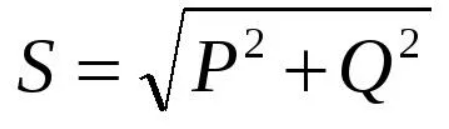

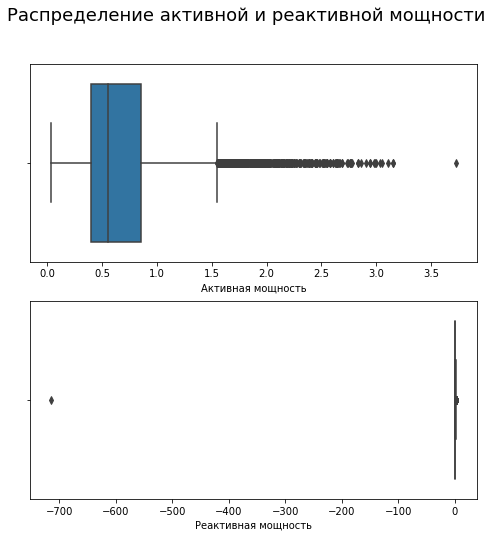

In [5]:
fig, axes = plt.subplots(2,1, figsize=(8,8))

sns.boxplot(data_arc['Активная мощность'], ax=axes[0])
sns.boxplot(data_arc['Реактивная мощность'], ax=axes[1])

plt.suptitle('Распределение активной и реактивной мощности', size=18);

В каждом признаке есть по одному выбросу. Рассмотрим их

In [6]:
data_arc['Активная мощность'].sort_values()

7372     0.030002
5596     0.030188
5320     0.030190
2419     0.030563
4914     0.031630
           ...   
14200    3.052813
9870     3.107820
12424    3.150762
9226     3.156276
7799     3.731596
Name: Активная мощность, Length: 14876, dtype: float64

In [7]:
data_arc['Реактивная мощность'].sort_values()

9780    -715.504924
5596       0.020806
2419       0.021154
4914       0.022485
4633       0.022983
            ...    
13760      2.335088
12424      2.397032
9361       2.459959
9226       2.504206
7799       2.676388
Name: Реактивная мощность, Length: 14876, dtype: float64

В столбце активной мощности значение отличается на 10% от предыдущего - не думаю, что это выброс, возмжно был долгий процесс плавления.Есть одна строчка с выбросом, где значение реактивной мощности равно -715. Возможно что перепутали размерности Вт и МВт. Рассмотрим эту партию

In [8]:
data_arc.loc[9780]

key                                    2116
Начало нагрева дугой    2019-07-24 00:44:48
Конец нагрева дугой     2019-07-24 00:46:37
Активная мощность                  0.495782
Реактивная мощность             -715.504924
Name: 9780, dtype: object

In [9]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Трудно предположить откуда взялось это значение, ведь если бы поменялась размерность, то не было бы минуса. В целом можно заметить, что с увеличением активной мощности, значение реактивной тоже возрастает, поэтому заменим выброс средним по этой партии.

In [10]:
mean_r_power = data_arc[(data_arc['key'] == 2116) & (data_arc['Реактивная мощность'] > 0)]['Реактивная мощность'].mean()
data_arc.loc[9780, 'Реактивная мощность'] = mean_r_power

Посмотрим на новое распределение мощностей

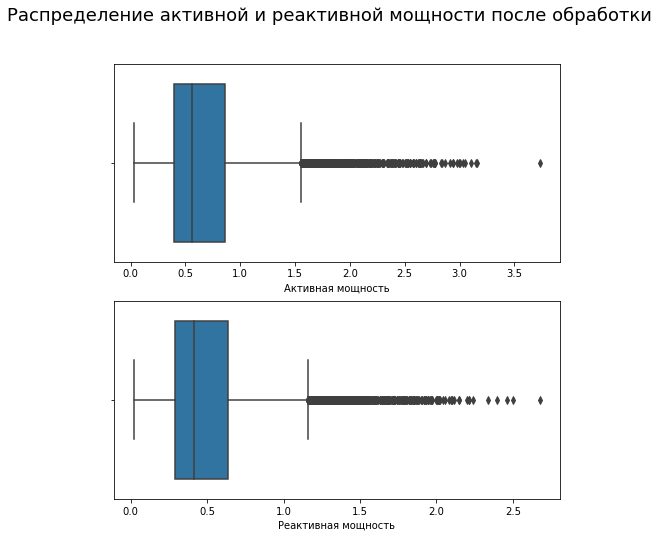

In [11]:
fig, axes = plt.subplots(2,1, figsize=(8,8))

sns.boxplot(data_arc['Активная мощность'], ax=axes[0])
sns.boxplot(data_arc['Реактивная мощность'], ax=axes[1])

plt.suptitle('Распределение активной и реактивной мощности после обработки', size=18);

Все также присутствуют некоторые выбивающиеся значения, но предположу, что в некоторые партии имели высокую удельную теплоту плавления материала, поэтому электроды потребляли больше мощности.

Проверим на корреляцию наши мощности:

In [12]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9631812415341249

Корреляция очень высокая, но это неудивительно. Убеждаемся, что формула из электротехники очень пригодится, ведь модель с двумя коррелирующими признаками может дать плохой результат.

In [13]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


Посмотрим какое количество партий всего попали в нашу выборку.

In [14]:
keys_values = data_arc['key'].unique()
print('Всего {} партий'.format(len(keys_values))) 

Всего 3214 партий


Всего в выборке с нагревом электродов есть данные по 3214 партиям, хотя датасет заканчивается на 3241, из чего можно сделать вывод, что по каким-то партиям данные не вошли в датасет, возможно они были забракованы.

Думаю, что для финальной модели нам понадобится такой параметр как время нагрева - найдем его как разность конца и начала нагрева дугой. Также, чтобы уменьшить количество признаков для финальной модели, можно перемножить время на потребляемую мощность и тогда получится параметр потребляемой энергии на весь нагрев.

In [15]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Время нагрева'] = ((data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()
                                   .astype(int))

In [16]:
data_arc['Затраченная энергия'] = data_arc['Полная мощность']* data_arc['Время нагрева']

Если мощность измерялась в МВт, то энергия получится в МДж.

In [17]:
data_arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Затраченная энергия
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,157,100.581755
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,180,154.000682
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,184,160.919002
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,57,15.075853
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,0.364260,81,29.505051


### Данные о подаче сыпучих материалов (объём)

In [18]:
info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов в датасете: 0


В датасете представлена информация о сыпучих материалах, где строка дает инфрмацию, какие добавки были введены в одну партию материала. Количество и состав зависят от химического состава материала. Пропуски в таблице означают, что добавка не использовалась ( можно будет заменить на 0). Также следует учесть, что информация о присадках существует не по всем партиям.

Посмотрим на выбросы

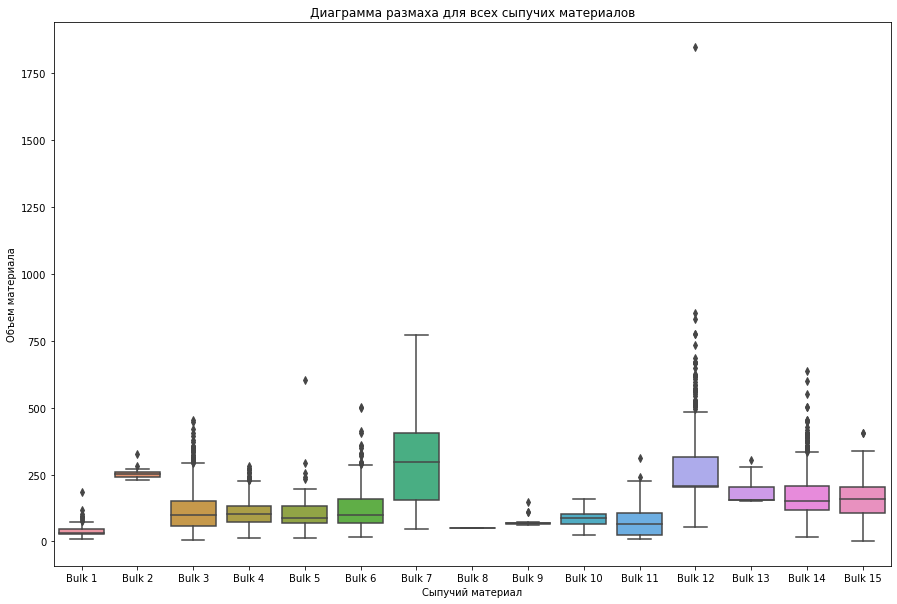

In [19]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data = data_bulk.drop('key', axis=1))
plt.xlabel("Сыпучий материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех сыпучих материалов");

Из графика можно увидеть, что во всех признаках присутствуют выбросы, за исключением Bulk 7, 8 и 10. Тяжело судить о том, сколько и каких нужно сыпучих материалов для плавления, да и тем более когда они зашифрованы. Поэтому будет целесообразно не трогать данные и посмотреть как это скажется на модели.

### Данные о подаче сыпучих материалов (время)

In [20]:
info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов в датасете: 0


Данные о времени сыпучих материалов имеют ту же структуру, пропуски означают 0, и дана лишь информация о времени введения материала. Так как у нас задача не связана с временными рядами, то предполагаю, что эта таблица нам не понадобится.

### Данные о продувке сплава газом

In [21]:
info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов в датасете: 0


В датасете присутствует 3239 строчки - на две меньше, чем в таблице про электроды. Возможно данные потерялись. Газ добавляется в каждую партию - нулевых значений нет.

Посмотрим на распределение данных:

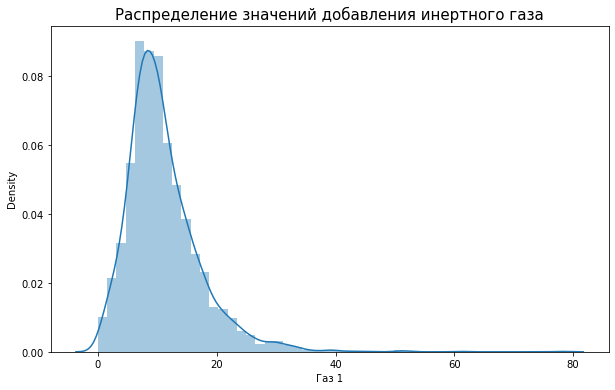

In [22]:
fig = plt.figure(figsize=(10,6))
sns.distplot(data_gas['Газ 1'])
plt.title('Распределение значений добавления инертного газа', size=15);

Данные распределены нормально с небольшим скосом вправо. Есть несколько выбросов, но предположу что здесь как с добавками - возможно в некоторых случаях нужно большое количество газа.

### Результаты измерения температуры

In [23]:
info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество дубликатов в датасете: 0


В датасете присутствуют 15907 записей об измерении температуры. Их на 1031 больше, чем записей об электродах. Стоит уточнить этот вопрос.

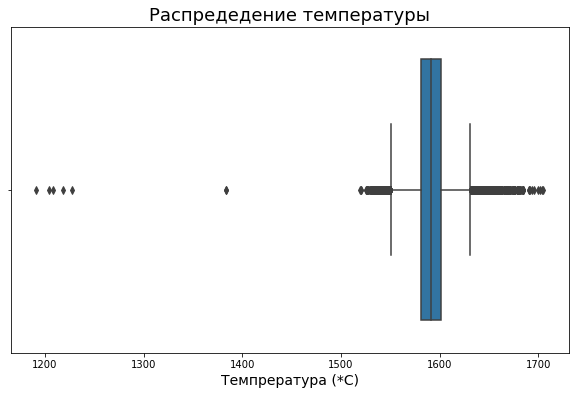

In [24]:
plt.figure(figsize=(10,6))

sns.boxplot(data_temp['Температура'])

plt.xlabel('Темпрература (*С)', size=14)
plt.title('Распредедение температуры', size=18);

Присутствует некоторое количество выбросов. Самое главное определить сколько значений меньше 1500 градусов - примерная температура кристаллизации стали.

In [25]:
tmp = data_temp[data_temp['Температура'] < 1500]
tmp.value_counts()

key   Время замера         Температура
867   2019-06-04 14:21:00  1191.0         1
1214  2019-06-16 05:32:00  1208.0         1
1619  2019-06-30 11:03:54  1218.0         1
1818  2019-07-07 00:30:49  1383.0         1
      2019-07-07 00:31:40  1383.0         1
2052  2019-07-21 14:51:40  1227.0         1
2561  2019-08-08 07:34:15  1204.0         1
dtype: int64

В 7 случаях металл находится нерасплавленным. Сбой данных или оборудования?

In [26]:
data_temp['Температура'].isna().sum()

2901

Получилось много пропущенных данных, нужно уточнить у заказчика что с ними делать. Там где данные полные будем брать первую температуру для признака модели и последний замер как таргет. Также предположу, что стоит удалять строки где температура 1500 градусов.

### Данные о проволочных материалах (объём)

In [27]:
info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов в датасете: 0


In [28]:
len(data_wire['key'].value_counts())

3081

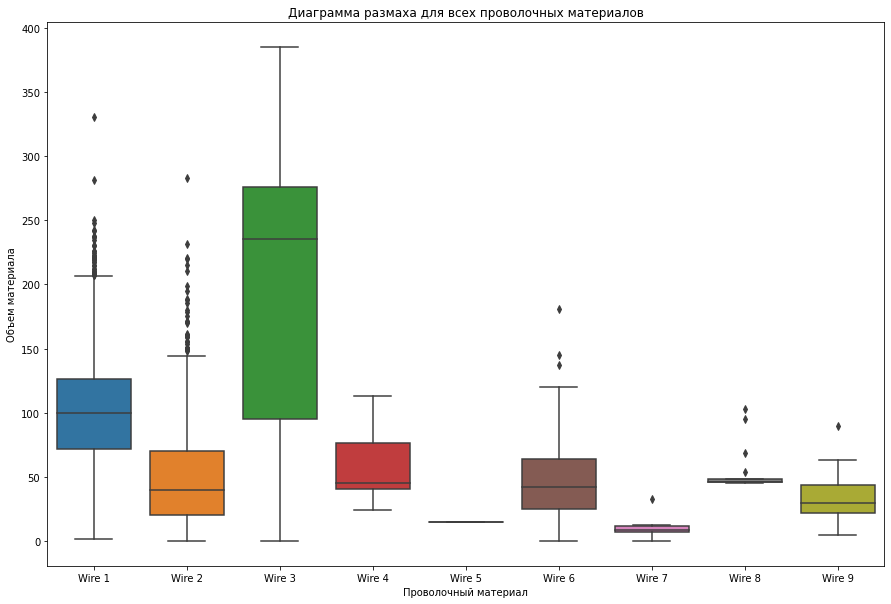

In [29]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data = data_wire.drop('key', axis=1))
plt.xlabel("Проволочный материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех проволочных материалов");

Из таблицы можно увидеть, что в расплавленный металл добавляют 9 проволочных материалов. Пропуски данных означают, что это материал не добавляли, можно заменить на 0. Самые заметные выбросы у проволки под номером 8. Однако нет уверенности, что их можно удалять - пока что оставим. Заметим, что в основном добавляют только первый и второй материал.

### Данные о проволочных материалах (время)

In [30]:
info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество дубликатов в датасете: 0


Аналогично информации о времени сыпучих материалов, здесь дадасет содержит информацию о времени добавления. Эти данные мы добавлять не будем, поэтому обрабатывать их смысла нет.

### План работы:

1. Предобработка данных
Обработка выбросов, заполнение пропусков при необходимости. Решить вопрос о недостающих данных (особенно важные вопросы по температуре).

2. Подбор необходимых фич
Определить важность столбцов Bulk и Wire (в основном в сплавы добавляют лишь малую часть). Подумать над созданием новых признаков и оценить новый столбец в электродах про энергозатратность.

3. Объединение данных в одну таблицу
Выделение feature и target признаков. Масштабирование данных при необходимости.

4. Подбор и обучение моделей
Разделить итоговый  датасет на 3 выборки, подбор гиперпараметров на валидационной выборке, проверки моделей на адекватность.

5. Выбор и тестирование финальной модели
Проверка модели на тестовой выборке. Создать таблицу о результатах всех модлей. Выделить важные признаки модели. Описать полученные результаты. 

## Предобработка данных

Продолжим готовить наш датасет к машинному обучению. Начнем с таблицы о температуре.  По справочнику температура плавления стали варируется от 1300 до 1500 градусов Цельсия. Возьмеме среднее значение в 1400 градусов, а также удалим все пропуски.

In [31]:
data_temp = data_temp.dropna()

In [32]:
data_temp = data_temp[data_temp['Температура'] >= 1400]

In [33]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [34]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [35]:
data_temp = data_temp.sort_values(by=['key', 'Время замера'])
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Данные отсортированы, сделаем группировку с подсчетом количества и выборкой первого и последнего значений.

In [36]:
data_temp_new = data_temp.groupby('key').agg({'Температура': ['count', 'first', 'last']}).reset_index()
data_temp_new

key Температура                
                 count   first    last
0        1           5  1571.0  1613.0
1        2           6  1581.0  1602.0
2        3           5  1596.0  1599.0
3        4           3  1601.0  1625.0
4        5           2  1576.0  1602.0
...    ...         ...     ...     ...
3210  3237           1  1569.0  1569.0
3211  3238           1  1584.0  1584.0
3212  3239           1  1598.0  1598.0
3213  3240           1  1617.0  1617.0
3214  3241           1  1586.0  1586.0

[3215 rows x 4 columns]

Переименуем столбцы:

In [37]:
data_temp_new.columns = ['key', 'num_temp_mes', 
              'initial_temp', 'final_temp']

Проверим работу на примере 4-ой партии.

In [38]:
data_temp[data_temp['key'] == 4]

,key,Время замера,Температура
16,4,2019-05-03 12:52:57,1601.0
17,4,2019-05-03 12:58:43,1623.0
18,4,2019-05-03 12:59:25,1625.0


Удалим партии, где был совершен только 1 замер:

In [39]:
data_temp_new = data_temp_new[data_temp_new['num_temp_mes'] > 1]

In [40]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2475 non-null   int64  
 1   num_temp_mes  2475 non-null   int64  
 2   initial_temp  2475 non-null   float64
 3   final_temp    2475 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 96.7 KB


In [41]:
data_temp_new.tail()

,key,num_temp_mes,initial_temp,final_temp
2472,2495,3,1570.0,1591.0
2473,2496,4,1554.0,1591.0
2474,2497,2,1571.0,1589.0
2475,2498,5,1591.0,1594.0
2476,2499,3,1569.0,1603.0


Выполним предобработку данных о сыпучих материалах. По совету тимлида удалим строки, которые выходят за тройной межквартильный рахмах. Пропуски же заменим на 0.

In [42]:
def delete_outliers(data, column):
    Q1 = data[column].quantile(0.25)                 
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data = data.drop(np.where((data[column] < (Q1-3*IQR)) | (data[column] > (Q3+3*IQR)))[0])
    return data

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ок, НО на правктике - обязательно эти партии надо обсудить с бизнесом. Может, всё-таки, они ему важны в исходных данных. 

In [43]:
for col in data_bulk.columns:
    data_bulk = delete_outliers(data_bulk, col)

In [44]:
data_bulk = data_bulk.fillna(0)

In [45]:
data_bulk.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
321,344,0.0,0.0,0.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,131.0,203.0
1724,1785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,0.0
1297,1349,0.0,0.0,0.0,0.0,0.0,143.0,0.0,0.0,0.0,0.0,0.0,153.0,0.0,206.0,63.0
1696,1756,0.0,0.0,252.0,0.0,70.0,81.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,99.0,204.0
1179,1228,0.0,0.0,0.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,104.0,204.0


Аналогично сделаем предобработку для данных о проволчных материалах:

In [46]:
data_wire = data_wire.fillna(0)

In [47]:
data_wire.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1178,1246,134.175598,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2660,2799,176.336166,59.234241,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1782,1872,115.081200,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1834,1924,82.074720,25.062960,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1232,1301,99.122398,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Доделаем до конца работу с таблицей о электродах. Чтобы получить финальную таблицу, нам нужно в этом датасете сгруппировать значения энергии по номерам партий:

In [48]:
data_arc_new = data_arc.groupby('key').agg({'Затраченная энергия': 'sum'}).reset_index()
data_arc_new.head(10)

,key,Затраченная энергия
0,1,1442.377754
1,2,881.233565
2,3,525.066777
3,4,796.911309
4,5,1199.137958
5,6,1410.747219
6,7,729.780631
7,8,1550.542227
8,9,406.460647
9,10,617.361506


### Cоздание финального датасета

Самым важным признаком является наличие конечной температуры, поэтому к этому датасету будем добавлять все остальные методом merge (how = 'left').


In [49]:
data_final = data_temp_new.merge(data_arc_new, on=['key'], how='left')
data_final = data_final.merge(data_bulk, on=['key'], how='left')
data_final = data_final.merge(data_gas, on=['key'], how='left')
data_final = data_final.merge(data_wire, on=['key'], how='left')

In [50]:
info(data_final)

,key,num_temp_mes,initial_temp,final_temp,Затраченная энергия,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,1571.0,1613.0,1442.377754,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6,1581.0,1602.0,881.233565,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,1596.0,1599.0,525.066777,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,1601.0,1625.0,796.911309,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,1576.0,1602.0,1199.137958,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,5,1543.0,1596.0,1410.747219,0.0,0.0,0.0,117.0,0.0,...,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,5,1586.0,1599.0,729.780631,0.0,0.0,0.0,117.0,0.0,...,9.836267,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,4,1577.0,1598.0,1550.542227,0.0,0.0,0.0,99.0,0.0,...,15.171553,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,5,1587.0,1592.0,406.460647,0.0,0.0,0.0,117.0,0.0,...,8.216623,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,8,1574.0,1593.0,617.361506,0.0,0.0,0.0,0.0,0.0,...,6.529891,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2475 non-null   int64  
 1   num_temp_mes         2475 non-null   int64  
 2   initial_temp         2475 non-null   float64
 3   final_temp           2475 non-null   float64
 4   Затраченная энергия  2475 non-null   float64
 5   Bulk 1               2383 non-null   float64
 6   Bulk 2               2383 non-null   float64
 7   Bulk 3               2383 non-null   float64
 8   Bulk 4               2383 non-null   float64
 9   Bulk 5               2383 non-null   float64
 10  Bulk 6               2383 non-null   float64
 11  Bulk 7               2383 non-null   float64
 12  Bulk 8               2383 non-null   float64
 13  Bulk 9               2383 non-null   float64
 14  Bulk 10              2383 non-null   float64
 15  Bulk 11              2383 non-null   f

None

,key,num_temp_mes,initial_temp,final_temp,Затраченная энергия,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,...,2473.000000,2372.000000,2372.000000,2372.000000,2372.000000,2372.0,2372.000000,2372.000000,2372.000000,2372.000000
mean,1250.787071,4.953131,1589.029899,1595.336162,904.086264,3.166597,1.253882,45.841376,36.069660,2.533361,...,11.142960,102.264474,17.856377,3.176273,0.300993,0.0,0.961076,0.006245,0.305667,0.414319
std,719.787271,1.802334,24.998058,16.023153,655.389650,11.423179,17.661684,74.169876,58.022204,22.036657,...,6.323742,43.641222,33.944219,27.691693,4.714583,0.0,8.615099,0.203833,4.362799,4.331678
min,1.000000,2.000000,1519.000000,1541.000000,15.158096,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,629.500000,4.000000,1572.000000,1587.000000,461.064980,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.105241,72.859018,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1252.000000,5.000000,1588.000000,1593.000000,768.075789,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.926730,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1872.500000,6.000000,1605.000000,1599.000000,1168.490883,0.000000,0.000000,76.000000,74.500000,0.000000,...,13.872219,128.143076,23.162880,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,16.000000,1679.000000,1700.000000,10630.980668,94.000000,282.000000,454.000000,281.000000,603.000000,...,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,90.053604


Количество дубликатов в датасете: 0


Видим, что по некоторым строкам не хватает данных, поэтому придется их удалить.

In [51]:
data_final = data_final.dropna()
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2306 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2306 non-null   int64  
 1   num_temp_mes         2306 non-null   int64  
 2   initial_temp         2306 non-null   float64
 3   final_temp           2306 non-null   float64
 4   Затраченная энергия  2306 non-null   float64
 5   Bulk 1               2306 non-null   float64
 6   Bulk 2               2306 non-null   float64
 7   Bulk 3               2306 non-null   float64
 8   Bulk 4               2306 non-null   float64
 9   Bulk 5               2306 non-null   float64
 10  Bulk 6               2306 non-null   float64
 11  Bulk 7               2306 non-null   float64
 12  Bulk 8               2306 non-null   float64
 13  Bulk 9               2306 non-null   float64
 14  Bulk 10              2306 non-null   float64
 15  Bulk 11              2306 non-null   f

Получили ровно 2300 строк для нашей будущей модели (где-то остался довольным перфекционист). Заранеем переименуем столбцы, так как у некотрых моделей могут возникнуть проблемы с русским текстом. Также приведем все к нижнему регистру:

In [52]:
data_final = data_final.rename(columns={'Затраченная энергия':'energy', 'Газ 1': 'gas'})
data_final.columns = [x.lower() for x in data_final.columns]

In [53]:
data_final

,key,num_temp_mes,initial_temp,final_temp,energy,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,...,gas,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,5,1571.0,1613.0,1442.377754,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6,1581.0,1602.0,881.233565,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,1596.0,1599.0,525.066777,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,1601.0,1625.0,796.911309,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,1576.0,1602.0,1199.137958,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,2493,3,1599.0,1594.0,386.851692,0.0,0.0,115.0,105.0,0.0,...,9.421691,122.172958,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,2496,4,1554.0,1591.0,875.261419,0.0,0.0,0.0,63.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,2497,2,1571.0,1589.0,556.930349,0.0,0.0,0.0,85.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,2498,5,1591.0,1594.0,767.817794,0.0,0.0,90.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Перед обучением еще стоит проверить признаки на мультиколлинеарность:

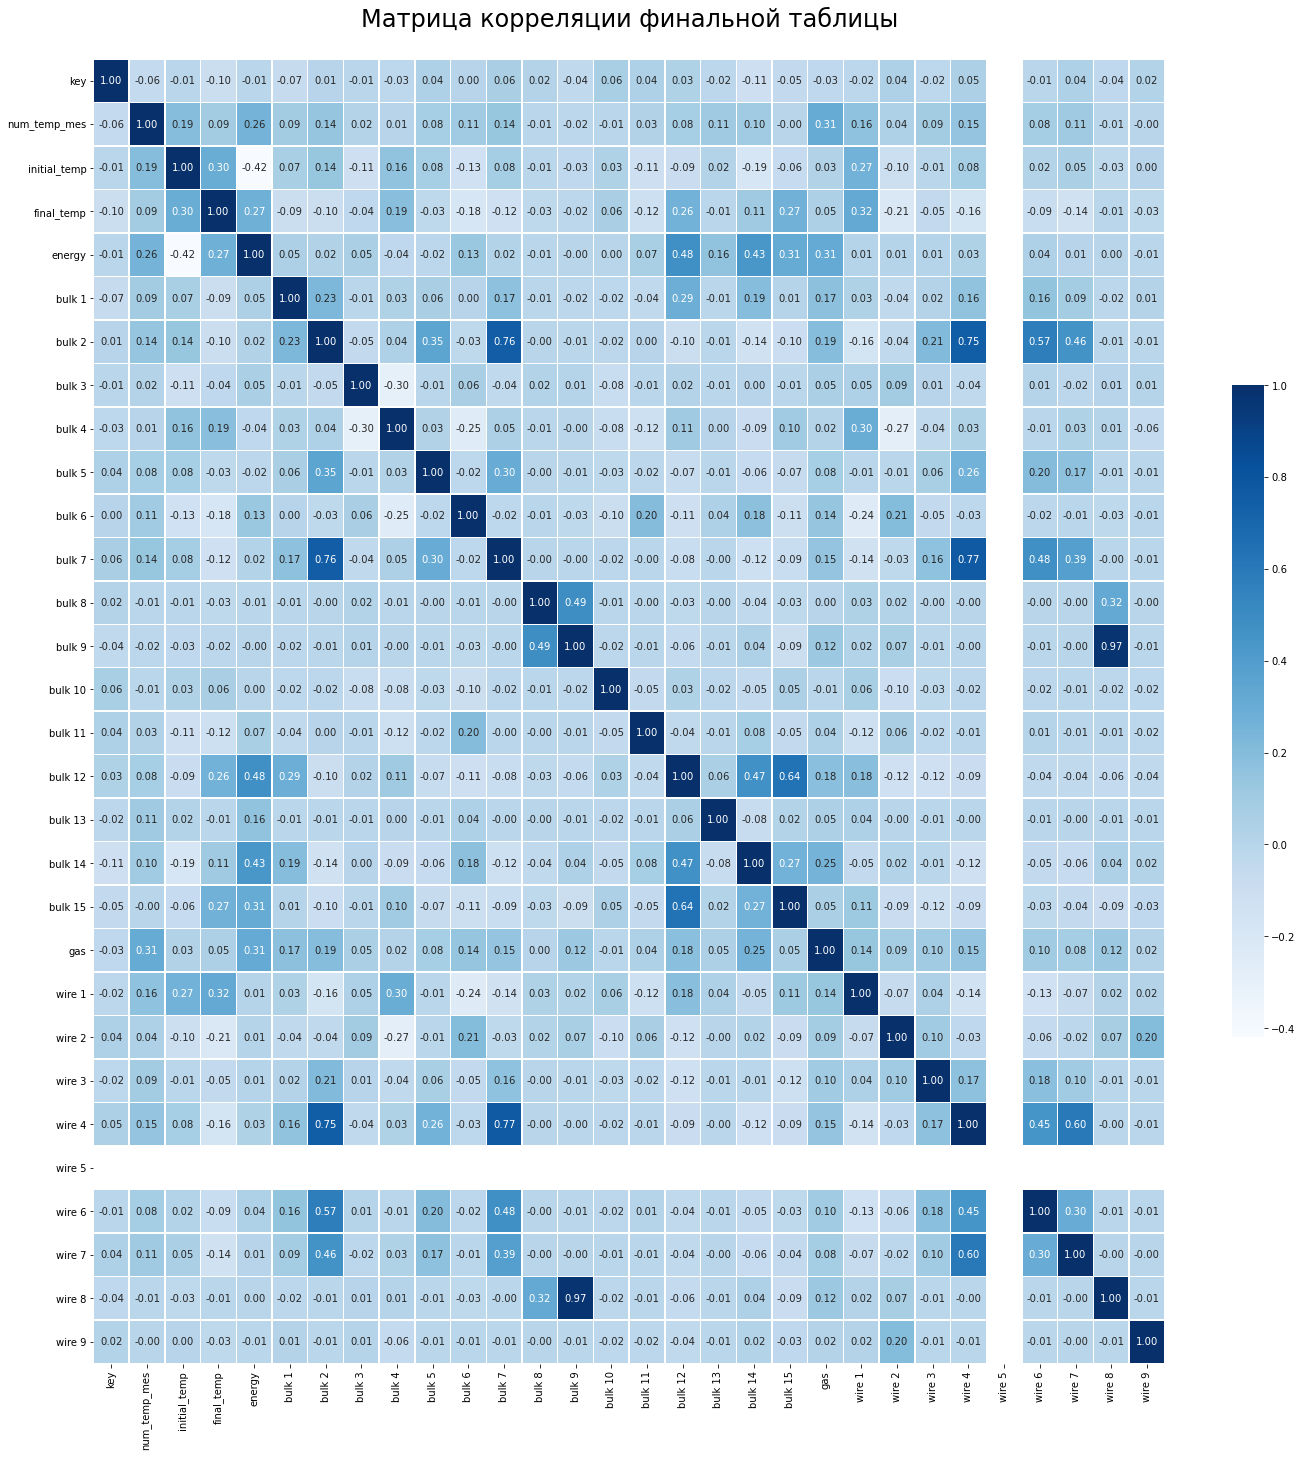

In [54]:
plt.figure(figsize=(24,24))
sns.heatmap(data_final.corr(), annot=True, cmap="Blues", fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Матрица корреляции финальной таблицы', size=24, y = 1.02);


Судя по матрице, на финальную температуру сильнее всего влияют начальная температура, энергия электродов, bulk 12 и 15, а также wire 1. Рассмотрим корреляции которые выше 0.75. Заметим, что столбец wire 5 имеет одни 0, поэтому будет целесообразно дропнуть его. Также удалим столбец key и num_temp_mes - они только помешают модели.

In [55]:
corr_table = data_final.corr().unstack().sort_values().drop_duplicates()
corr_table[(corr_table > 0.75) | (corr_table < -0.75)]

bulk 7  bulk 2    0.755267
        wire 4    0.770187
wire 8  bulk 9    0.974967
key     key       1.000000
dtype: float64

Думаю что корреляцию в районе 0.75 будет не критично оставить. А вот один из столбцов wire 8 и bulk 9 придется удалить. Посмотрим в каком из столбцов больше ненулевых значений:

In [56]:
print ((data_final['wire 8'] != 0).sum())
print ((data_final['bulk 9'] != 0).sum())

13
13


Какое удивительное совпадение, у них одинаковое количество значений. Раз у нас столбцов bulk больше, то удалим его.

In [57]:
data_final = data_final.drop(['bulk 9', 'key', 'num_temp_mes', 'wire 5'], axis = 1)

In [58]:
data_final.describe()

,initial_temp,final_temp,energy,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,...,bulk 15,gas,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 8,wire 9
count,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,...,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000,2306.000000
mean,1587.393755,1593.370772,901.375120,3.272333,1.295750,47.152212,37.145707,2.617953,22.467910,1.848656,...,120.227667,11.333635,102.552332,17.577806,3.226821,0.309607,0.976885,0.006424,0.314416,0.307222
std,23.552282,11.202223,649.819431,11.597497,17.952749,74.847581,58.506388,22.396762,55.830197,29.657219,...,84.493241,6.190255,43.382883,33.455280,28.017745,4.781325,8.719243,0.206728,4.424508,3.417759
min,1519.000000,1541.000000,15.158096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,464.038081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.284220,73.581300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1587.000000,1593.000000,767.593080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,107.000000,10.103073,101.181599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1603.000000,1598.000000,1164.624553,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,...,204.000000,14.206940,128.107974,23.145980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1660.000000,1653.000000,10630.980668,94.000000,282.000000,454.000000,281.000000,603.000000,503.000000,772.000000,...,405.000000,60.935689,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


In [59]:
data_final.sample(5)

,initial_temp,final_temp,energy,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,...,bulk 15,gas,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 8,wire 9
2287,1540.0,1583.0,1504.290871,0.0,0.0,36.0,0.0,0.0,0.0,0.0,...,104.0,10.818560,105.050400,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1436,1583.0,1590.0,603.988581,0.0,0.0,98.0,0.0,0.0,0.0,0.0,...,102.0,10.262912,1.918800,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
790,1569.0,1585.0,681.916568,0.0,0.0,174.0,0.0,0.0,0.0,0.0,...,204.0,8.592236,87.188401,93.134079,0.0,0.0,0.0,0.0,0.0,0.0
1299,1579.0,1606.0,764.073090,0.0,0.0,50.0,0.0,0.0,0.0,0.0,...,0.0,8.291357,71.089195,11.219520,0.0,0.0,0.0,0.0,0.0,0.0
166,1566.0,1574.0,769.075999,0.0,0.0,114.0,0.0,0.0,0.0,0.0,...,153.0,9.824984,36.254399,117.149767,0.0,0.0,0.0,0.0,0.0,0.0


Данные готовы к машинному обучению:

## Машинное обучение

Начнем с разделения данных на обучающую и тестовую выборки. При подборе гиперпараметров будет использовать кросс-валидацию

In [60]:
target = data_final['final_temp']
features = data_final.drop('final_temp', axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state = RND)

In [62]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1844, 25) (462, 25) (1844,) (462,)


Напишем несколько функций, которые упростят на код:

In [63]:
# поиск гиперпараметров
def grid_search(model, params, features, target):
      
    search = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    search.fit(features, target)
    
    print(-search.best_score_)
    print(search.best_params_)

In [64]:
# предсказания и подсчет метрики на обучающей и тестовой выборках:

def prediction_train(model, train_features, train_target): 
    mae_train = mean_absolute_error(train_target, model.predict(train_features)) 
    print('MAE на обучающей выборке', mae_train.round(4))
    
def prediction_test(model, test_features, test_target):
    mae_test = mean_absolute_error(test_target, model.predict(test_features))
    print('MAE на тестовой выборке', mae_test.round(4))

In [65]:
# функция подсчета скоринга на кросс-валидации
def cv_score(model, features, target):
    
    score = cross_val_score(model, features, target, cv=5, scoring='neg_mean_absolute_error')
    
    print('Результат кросс валидации', -score.round(3))
    print('Усредненный результат', -score.mean().round(3))
    

По небольшому исследованию моделей, можно сказать что понадобится отмасштабировать модели

In [66]:
numeric = X_train.columns
scaler = StandardScaler()
scaler.fit(X_train[numeric])
    
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

### Проверка модели на адекватность

In [67]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [68]:
prediction_train(dummy, X_train, y_train)

MAE на обучающей выборке 7.9257


In [69]:
prediction_test(dummy, X_test, y_test)

MAE на тестовой выборке 8.5325


Модель-болванка уже дает неплохой результат на 4sp. Но все равно рассмотрим остальные модели

### Линейная регрессия

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [71]:
lr_params = dict(fit_intercept= [True,False], normalize=[True,False])

In [72]:
grid_search(lr, lr_params, X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
6.3821778010034595
{'fit_intercept': True, 'normalize': False}


In [73]:
lr = LinearRegression(fit_intercept = True, normalize = False)

In [74]:
%%time
lr.fit(X_train, y_train)

Wall time: 6.54 ms


LinearRegression()

In [75]:
cv_score(lr,  X_train, y_train)

Результат кросс валидации [6.471 6.105 6.173 6.251 6.91 ]
Усредненный результат 6.382


In [76]:
%%time
prediction_train(lr,  X_train, y_train)

MAE на обучающей выборке 6.0595
Wall time: 3.74 ms


Уже очень неплохой результат, усредненный на кросс-валидации близок к 6.5, на обучающей 6.2

### Random Forest Regressor

In [77]:
rfr = RandomForestRegressor(random_state=RND).fit(X_train, y_train)

In [78]:
rfr_params = dict(n_estimators = range(50, 81, 10), max_depth = range(7,12))

In [79]:
#grid_search(rfr, rfr_params, X_train, y_train)

In [80]:
rfr = RandomForestRegressor(random_state=RND, n_estimators = 60, max_depth = 9)

In [81]:
%%time
rfr.fit(X_train, y_train)

Wall time: 859 ms


RandomForestRegressor(max_depth=9, n_estimators=60, random_state=12345)

In [82]:
cv_score(rfr,  X_train, y_train)

Результат кросс валидации [6.451 5.873 5.739 6.122 6.227]
Усредненный результат 6.082


In [83]:
%%time
prediction_train(rfr,  X_train, y_train)

MAE на обучающей выборке 4.1025
Wall time: 33.4 ms


На кросс-валидации результат лучше чем у регрессии, однако еще далеко до идеала. На обучающей выборке видим переобучение

### LightGBM

In [84]:
%%time
lgbm = LGBMRegressor(random_state=RND).fit(X_train, y_train)

Wall time: 149 ms


In [85]:
lgbm_params = dict(num_leaves =range(7,19, 2), 
                   max_depth = np.arange(2, 5),
                   learning_rate = [0.04, 0.05, 0.06, 0.07],
                   n_estimators = np.arange(60, 151, 5))

In [86]:
#grid_search(lgbm, lgbm_params, X_train, y_train)

In [87]:
'''Fitting 5 folds for each of 1368 candidates, totalling 6840 fits
6.036497083130486
{'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 115, 'num_leaves': 9}'''

"Fitting 5 folds for each of 1368 candidates, totalling 6840 fits\n6.036497083130486\n{'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 115, 'num_leaves': 9}"

In [88]:
lgbm = LGBMRegressor(learning_rate = 0.06, max_depth = 3, num_leaves = 9, n_estimators = 145, random_state=RND)

In [89]:
%%time
lgbm.fit(X_train, y_train)

Wall time: 68.9 ms


LGBMRegressor(learning_rate=0.06, max_depth=3, n_estimators=145, num_leaves=9,
              random_state=12345)

In [90]:
cv_score(lgbm,  X_train, y_train)

Результат кросс валидации [6.323 5.69  5.625 6.022 6.022]
Усредненный результат 5.937


In [91]:
%%time
prediction_train(lgbm,  X_train, y_train)

MAE на обучающей выборке 5.0803
Wall time: 11.2 ms


С каждым разом усредненный результат на кросс-валидации все лучше. Заметим, что lightgbm менеше переобучился, по сравнению с лесом.

### GradientBoostingRegressor

In [92]:
gbr = GradientBoostingRegressor(random_state=RND).fit(X_train, y_train)

In [93]:
gbr_params = dict(learning_rate = [0.009, 0.01],
                  n_estimators=[550, 560], 
                  max_depth=[4,5,6],
                 min_samples_split = [1, 2, 3],
                 min_samples_leaf = [1, 2],
                 criterion = ['friedman_mse', 'squared_error', 'mse', 'mae'],
                 tol = [1e-03, 1e-04, 1e-05])

In [94]:
#grid_search(gbr, gbr_params, X_train, y_train)

In [95]:
gbr = GradientBoostingRegressor(random_state=RND, learning_rate=0.01, max_depth = 5, n_estimators = 560, subsample = 0.85, tol = 0.001)

In [96]:
%%time
gbr.fit(X_train, y_train)

Wall time: 5.97 s


GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=560,
                          random_state=12345, subsample=0.85, tol=0.001)

In [97]:
cv_score(gbr,  X_train, y_train)

Результат кросс валидации [6.314 5.728 5.655 5.991 5.905]
Усредненный результат 5.919


In [98]:
%%time
prediction_train(gbr,  X_train, y_train)

MAE на обучающей выборке 4.0111
Wall time: 62.1 ms


Модель градиентого бустинга показала хорошие результаты на кроссе, на обучающей переобучилась

### СatBoost

In [99]:
cbr = CatBoostRegressor(random_state=RND, loss_function="MAE") 
                        

In [100]:
cbr.fit(X_train, y_train)

0:	learn: 7.8806877	total: 151ms	remaining: 2m 30s
1:	learn: 7.8245853	total: 157ms	remaining: 1m 18s
2:	learn: 7.7756096	total: 163ms	remaining: 54.1s
3:	learn: 7.7042178	total: 168ms	remaining: 41.9s
4:	learn: 7.6396845	total: 174ms	remaining: 34.6s
5:	learn: 7.5759076	total: 179ms	remaining: 29.7s
6:	learn: 7.5191785	total: 184ms	remaining: 26.1s
7:	learn: 7.4834732	total: 189ms	remaining: 23.5s
8:	learn: 7.4297363	total: 194ms	remaining: 21.4s
9:	learn: 7.3918210	total: 200ms	remaining: 19.8s
10:	learn: 7.3372107	total: 205ms	remaining: 18.4s
11:	learn: 7.2926712	total: 210ms	remaining: 17.3s
12:	learn: 7.2459916	total: 215ms	remaining: 16.3s
13:	learn: 7.2090727	total: 220ms	remaining: 15.5s
14:	learn: 7.1663363	total: 224ms	remaining: 14.7s
15:	learn: 7.1282167	total: 230ms	remaining: 14.1s
16:	learn: 7.0986263	total: 234ms	remaining: 13.5s
17:	learn: 7.0534542	total: 239ms	remaining: 13s
18:	learn: 7.0135311	total: 244ms	remaining: 12.6s
19:	learn: 6.9769955	total: 249ms	remaini

182:	learn: 5.0925626	total: 1.04s	remaining: 4.67s
183:	learn: 5.0880095	total: 1.05s	remaining: 4.66s
184:	learn: 5.0837194	total: 1.05s	remaining: 4.65s
185:	learn: 5.0767695	total: 1.06s	remaining: 4.64s
186:	learn: 5.0732374	total: 1.06s	remaining: 4.63s
187:	learn: 5.0696864	total: 1.07s	remaining: 4.61s
188:	learn: 5.0637477	total: 1.07s	remaining: 4.61s
189:	learn: 5.0590390	total: 1.08s	remaining: 4.59s
190:	learn: 5.0540671	total: 1.08s	remaining: 4.58s
191:	learn: 5.0494539	total: 1.09s	remaining: 4.58s
192:	learn: 5.0474936	total: 1.09s	remaining: 4.57s
193:	learn: 5.0453448	total: 1.1s	remaining: 4.55s
194:	learn: 5.0391312	total: 1.1s	remaining: 4.55s
195:	learn: 5.0364202	total: 1.11s	remaining: 4.54s
196:	learn: 5.0330477	total: 1.11s	remaining: 4.53s
197:	learn: 5.0276749	total: 1.11s	remaining: 4.52s
198:	learn: 5.0245751	total: 1.12s	remaining: 4.51s
199:	learn: 5.0204038	total: 1.13s	remaining: 4.5s
200:	learn: 5.0170408	total: 1.13s	remaining: 4.49s
201:	learn: 5.0

367:	learn: 4.4558869	total: 1.93s	remaining: 3.32s
368:	learn: 4.4543422	total: 1.94s	remaining: 3.31s
369:	learn: 4.4533129	total: 1.94s	remaining: 3.31s
370:	learn: 4.4511631	total: 1.95s	remaining: 3.3s
371:	learn: 4.4492370	total: 1.95s	remaining: 3.29s
372:	learn: 4.4476002	total: 1.96s	remaining: 3.29s
373:	learn: 4.4449674	total: 1.96s	remaining: 3.28s
374:	learn: 4.4413528	total: 1.97s	remaining: 3.27s
375:	learn: 4.4388111	total: 1.97s	remaining: 3.27s
376:	learn: 4.4368100	total: 1.97s	remaining: 3.26s
377:	learn: 4.4345544	total: 1.98s	remaining: 3.26s
378:	learn: 4.4329583	total: 1.98s	remaining: 3.25s
379:	learn: 4.4317482	total: 1.99s	remaining: 3.24s
380:	learn: 4.4291347	total: 1.99s	remaining: 3.24s
381:	learn: 4.4258122	total: 2s	remaining: 3.23s
382:	learn: 4.4238813	total: 2s	remaining: 3.23s
383:	learn: 4.4215760	total: 2.01s	remaining: 3.22s
384:	learn: 4.4199110	total: 2.01s	remaining: 3.21s
385:	learn: 4.4155406	total: 2.02s	remaining: 3.21s
386:	learn: 4.41235

557:	learn: 4.0537425	total: 2.81s	remaining: 2.23s
558:	learn: 4.0514951	total: 2.82s	remaining: 2.22s
559:	learn: 4.0502558	total: 2.82s	remaining: 2.22s
560:	learn: 4.0490415	total: 2.83s	remaining: 2.21s
561:	learn: 4.0487846	total: 2.83s	remaining: 2.21s
562:	learn: 4.0441636	total: 2.83s	remaining: 2.2s
563:	learn: 4.0405843	total: 2.84s	remaining: 2.19s
564:	learn: 4.0360295	total: 2.84s	remaining: 2.19s
565:	learn: 4.0342265	total: 2.85s	remaining: 2.19s
566:	learn: 4.0336101	total: 2.85s	remaining: 2.18s
567:	learn: 4.0331183	total: 2.86s	remaining: 2.17s
568:	learn: 4.0310022	total: 2.86s	remaining: 2.17s
569:	learn: 4.0298507	total: 2.87s	remaining: 2.16s
570:	learn: 4.0284246	total: 2.87s	remaining: 2.16s
571:	learn: 4.0265943	total: 2.88s	remaining: 2.15s
572:	learn: 4.0239736	total: 2.88s	remaining: 2.15s
573:	learn: 4.0222376	total: 2.88s	remaining: 2.14s
574:	learn: 4.0216571	total: 2.89s	remaining: 2.13s
575:	learn: 4.0198413	total: 2.89s	remaining: 2.13s
576:	learn: 4

746:	learn: 3.7827812	total: 3.69s	remaining: 1.25s
747:	learn: 3.7815050	total: 3.7s	remaining: 1.25s
748:	learn: 3.7779819	total: 3.7s	remaining: 1.24s
749:	learn: 3.7777110	total: 3.71s	remaining: 1.24s
750:	learn: 3.7764817	total: 3.71s	remaining: 1.23s
751:	learn: 3.7759947	total: 3.71s	remaining: 1.23s
752:	learn: 3.7754557	total: 3.72s	remaining: 1.22s
753:	learn: 3.7746173	total: 3.72s	remaining: 1.21s
754:	learn: 3.7738566	total: 3.73s	remaining: 1.21s
755:	learn: 3.7732371	total: 3.73s	remaining: 1.2s
756:	learn: 3.7719472	total: 3.74s	remaining: 1.2s
757:	learn: 3.7702023	total: 3.74s	remaining: 1.19s
758:	learn: 3.7690373	total: 3.75s	remaining: 1.19s
759:	learn: 3.7678483	total: 3.75s	remaining: 1.18s
760:	learn: 3.7676498	total: 3.76s	remaining: 1.18s
761:	learn: 3.7660989	total: 3.76s	remaining: 1.17s
762:	learn: 3.7643079	total: 3.77s	remaining: 1.17s
763:	learn: 3.7635130	total: 3.77s	remaining: 1.16s
764:	learn: 3.7630621	total: 3.77s	remaining: 1.16s
765:	learn: 3.76

935:	learn: 3.5559441	total: 4.58s	remaining: 313ms
936:	learn: 3.5557756	total: 4.58s	remaining: 308ms
937:	learn: 3.5547435	total: 4.59s	remaining: 303ms
938:	learn: 3.5539751	total: 4.59s	remaining: 298ms
939:	learn: 3.5535259	total: 4.6s	remaining: 293ms
940:	learn: 3.5525084	total: 4.6s	remaining: 288ms
941:	learn: 3.5514929	total: 4.61s	remaining: 284ms
942:	learn: 3.5512200	total: 4.61s	remaining: 279ms
943:	learn: 3.5495128	total: 4.62s	remaining: 274ms
944:	learn: 3.5486644	total: 4.62s	remaining: 269ms
945:	learn: 3.5475227	total: 4.62s	remaining: 264ms
946:	learn: 3.5463114	total: 4.63s	remaining: 259ms
947:	learn: 3.5462446	total: 4.63s	remaining: 254ms
948:	learn: 3.5450484	total: 4.64s	remaining: 249ms
949:	learn: 3.5445292	total: 4.64s	remaining: 244ms
950:	learn: 3.5435328	total: 4.65s	remaining: 240ms
951:	learn: 3.5418277	total: 4.65s	remaining: 235ms
952:	learn: 3.5406471	total: 4.66s	remaining: 230ms
953:	learn: 3.5399934	total: 4.66s	remaining: 225ms
954:	learn: 3.

In [101]:
cbr_params = dict(iterations = [1100, 1200, 1300, 1400, 1500], 
                   max_depth = [4, 5, 6],
                   learning_rate = [0.03, 0.04, 0.05],
                   subsample = [0.65, 0.7, 0.75],
                  )


In [102]:
#grid_search(cbr, cbr_params, X_train, y_train)

In [103]:
'''5.913370028452354
{'iterations': 1200, 'learning_rate': 0.04, 'max_depth': 5, 'subsample': 0.7}}'''

"5.913370028452354\n{'iterations': 1200, 'learning_rate': 0.04, 'max_depth': 5, 'subsample': 0.7}}"

In [104]:
%%time
cbr = CatBoostRegressor(random_state=RND, loss_function="MAE", iterations=1200, learning_rate = 0.04, max_depth = 4, subsample = 0.7) 

Wall time: 0 ns


In [105]:
%%time
cbr.fit(X_train, y_train, verbose = 0)

Wall time: 2.73 s


In [106]:
cv_score(cbr,  X_train, y_train)

0:	learn: 7.8211244	total: 2.75ms	remaining: 3.29s
1:	learn: 7.7380817	total: 5.54ms	remaining: 3.32s
2:	learn: 7.6911125	total: 8.14ms	remaining: 3.25s
3:	learn: 7.6302997	total: 10.7ms	remaining: 3.21s
4:	learn: 7.5848882	total: 13.2ms	remaining: 3.15s
5:	learn: 7.5380202	total: 15.5ms	remaining: 3.08s
6:	learn: 7.5091322	total: 18.1ms	remaining: 3.09s
7:	learn: 7.4408891	total: 20.4ms	remaining: 3.04s
8:	learn: 7.4019991	total: 22.1ms	remaining: 2.92s
9:	learn: 7.3370824	total: 24ms	remaining: 2.85s
10:	learn: 7.2886276	total: 26ms	remaining: 2.81s
11:	learn: 7.2531182	total: 27.8ms	remaining: 2.75s
12:	learn: 7.1884914	total: 30.1ms	remaining: 2.75s
13:	learn: 7.1352234	total: 32.7ms	remaining: 2.77s
14:	learn: 7.0917925	total: 34.9ms	remaining: 2.76s
15:	learn: 7.0467696	total: 36.8ms	remaining: 2.72s
16:	learn: 6.9979156	total: 39.4ms	remaining: 2.74s
17:	learn: 6.9715959	total: 41.5ms	remaining: 2.73s
18:	learn: 6.9533724	total: 44.1ms	remaining: 2.74s
19:	learn: 6.9160741	total

203:	learn: 5.1946060	total: 468ms	remaining: 2.28s
204:	learn: 5.1925900	total: 470ms	remaining: 2.28s
205:	learn: 5.1895341	total: 471ms	remaining: 2.27s
206:	learn: 5.1865588	total: 474ms	remaining: 2.27s
207:	learn: 5.1842159	total: 475ms	remaining: 2.27s
208:	learn: 5.1785450	total: 477ms	remaining: 2.26s
209:	learn: 5.1758286	total: 479ms	remaining: 2.26s
210:	learn: 5.1718761	total: 481ms	remaining: 2.25s
211:	learn: 5.1691504	total: 482ms	remaining: 2.25s
212:	learn: 5.1670925	total: 484ms	remaining: 2.24s
213:	learn: 5.1645888	total: 487ms	remaining: 2.24s
214:	learn: 5.1578752	total: 488ms	remaining: 2.24s
215:	learn: 5.1530949	total: 491ms	remaining: 2.23s
216:	learn: 5.1496955	total: 492ms	remaining: 2.23s
217:	learn: 5.1440708	total: 494ms	remaining: 2.23s
218:	learn: 5.1421863	total: 496ms	remaining: 2.22s
219:	learn: 5.1384019	total: 499ms	remaining: 2.22s
220:	learn: 5.1343361	total: 501ms	remaining: 2.22s
221:	learn: 5.1308699	total: 503ms	remaining: 2.21s
222:	learn: 

378:	learn: 4.7444910	total: 851ms	remaining: 1.84s
379:	learn: 4.7421151	total: 853ms	remaining: 1.84s
380:	learn: 4.7381456	total: 855ms	remaining: 1.84s
381:	learn: 4.7367751	total: 857ms	remaining: 1.84s
382:	learn: 4.7345789	total: 860ms	remaining: 1.83s
383:	learn: 4.7330818	total: 862ms	remaining: 1.83s
384:	learn: 4.7311448	total: 863ms	remaining: 1.83s
385:	learn: 4.7290350	total: 865ms	remaining: 1.82s
386:	learn: 4.7271752	total: 867ms	remaining: 1.82s
387:	learn: 4.7261812	total: 870ms	remaining: 1.82s
388:	learn: 4.7237711	total: 872ms	remaining: 1.82s
389:	learn: 4.7229126	total: 873ms	remaining: 1.81s
390:	learn: 4.7219176	total: 876ms	remaining: 1.81s
391:	learn: 4.7198246	total: 878ms	remaining: 1.81s
392:	learn: 4.7190396	total: 880ms	remaining: 1.81s
393:	learn: 4.7169427	total: 882ms	remaining: 1.8s
394:	learn: 4.7162816	total: 884ms	remaining: 1.8s
395:	learn: 4.7124713	total: 886ms	remaining: 1.8s
396:	learn: 4.7109996	total: 888ms	remaining: 1.8s
397:	learn: 4.70

573:	learn: 4.4443743	total: 1.31s	remaining: 1.43s
574:	learn: 4.4432652	total: 1.32s	remaining: 1.43s
575:	learn: 4.4429746	total: 1.32s	remaining: 1.43s
576:	learn: 4.4414447	total: 1.32s	remaining: 1.43s
577:	learn: 4.4393067	total: 1.32s	remaining: 1.42s
578:	learn: 4.4388498	total: 1.32s	remaining: 1.42s
579:	learn: 4.4379828	total: 1.33s	remaining: 1.42s
580:	learn: 4.4364119	total: 1.33s	remaining: 1.42s
581:	learn: 4.4335970	total: 1.33s	remaining: 1.41s
582:	learn: 4.4321164	total: 1.33s	remaining: 1.41s
583:	learn: 4.4303697	total: 1.34s	remaining: 1.41s
584:	learn: 4.4282757	total: 1.34s	remaining: 1.41s
585:	learn: 4.4271501	total: 1.34s	remaining: 1.41s
586:	learn: 4.4261940	total: 1.34s	remaining: 1.4s
587:	learn: 4.4261179	total: 1.34s	remaining: 1.4s
588:	learn: 4.4248604	total: 1.35s	remaining: 1.4s
589:	learn: 4.4220473	total: 1.35s	remaining: 1.4s
590:	learn: 4.4202116	total: 1.35s	remaining: 1.39s
591:	learn: 4.4195540	total: 1.35s	remaining: 1.39s
592:	learn: 4.41

745:	learn: 4.2374464	total: 1.7s	remaining: 1.03s
746:	learn: 4.2366854	total: 1.7s	remaining: 1.03s
747:	learn: 4.2350556	total: 1.7s	remaining: 1.03s
748:	learn: 4.2336975	total: 1.7s	remaining: 1.02s
749:	learn: 4.2322532	total: 1.71s	remaining: 1.02s
750:	learn: 4.2312387	total: 1.71s	remaining: 1.02s
751:	learn: 4.2306796	total: 1.71s	remaining: 1.02s
752:	learn: 4.2295159	total: 1.71s	remaining: 1.02s
753:	learn: 4.2278080	total: 1.71s	remaining: 1.01s
754:	learn: 4.2267774	total: 1.72s	remaining: 1.01s
755:	learn: 4.2248518	total: 1.72s	remaining: 1.01s
756:	learn: 4.2234944	total: 1.72s	remaining: 1.01s
757:	learn: 4.2222335	total: 1.72s	remaining: 1s
758:	learn: 4.2212047	total: 1.73s	remaining: 1s
759:	learn: 4.2202690	total: 1.73s	remaining: 1s
760:	learn: 4.2191553	total: 1.73s	remaining: 998ms
761:	learn: 4.2173574	total: 1.73s	remaining: 995ms
762:	learn: 4.2164889	total: 1.73s	remaining: 993ms
763:	learn: 4.2155174	total: 1.74s	remaining: 990ms
764:	learn: 4.2147220	tot

963:	learn: 4.0481920	total: 2.17s	remaining: 531ms
964:	learn: 4.0477073	total: 2.17s	remaining: 529ms
965:	learn: 4.0472429	total: 2.17s	remaining: 526ms
966:	learn: 4.0469293	total: 2.17s	remaining: 524ms
967:	learn: 4.0463060	total: 2.18s	remaining: 522ms
968:	learn: 4.0458486	total: 2.18s	remaining: 520ms
969:	learn: 4.0448870	total: 2.18s	remaining: 517ms
970:	learn: 4.0438189	total: 2.18s	remaining: 515ms
971:	learn: 4.0415969	total: 2.19s	remaining: 513ms
972:	learn: 4.0411551	total: 2.19s	remaining: 511ms
973:	learn: 4.0407044	total: 2.19s	remaining: 508ms
974:	learn: 4.0398486	total: 2.19s	remaining: 506ms
975:	learn: 4.0384099	total: 2.19s	remaining: 504ms
976:	learn: 4.0381010	total: 2.2s	remaining: 502ms
977:	learn: 4.0366544	total: 2.2s	remaining: 499ms
978:	learn: 4.0358757	total: 2.2s	remaining: 497ms
979:	learn: 4.0355205	total: 2.2s	remaining: 495ms
980:	learn: 4.0348934	total: 2.21s	remaining: 493ms
981:	learn: 4.0340515	total: 2.21s	remaining: 490ms
982:	learn: 4.03

1130:	learn: 3.9391126	total: 2.55s	remaining: 156ms
1131:	learn: 3.9378692	total: 2.55s	remaining: 153ms
1132:	learn: 3.9368958	total: 2.56s	remaining: 151ms
1133:	learn: 3.9365765	total: 2.56s	remaining: 149ms
1134:	learn: 3.9363167	total: 2.56s	remaining: 147ms
1135:	learn: 3.9347525	total: 2.58s	remaining: 145ms
1136:	learn: 3.9337838	total: 2.58s	remaining: 143ms
1137:	learn: 3.9331581	total: 2.58s	remaining: 141ms
1138:	learn: 3.9314792	total: 2.58s	remaining: 138ms
1139:	learn: 3.9313260	total: 2.59s	remaining: 136ms
1140:	learn: 3.9311262	total: 2.59s	remaining: 134ms
1141:	learn: 3.9307169	total: 2.59s	remaining: 132ms
1142:	learn: 3.9304496	total: 2.59s	remaining: 129ms
1143:	learn: 3.9302686	total: 2.6s	remaining: 127ms
1144:	learn: 3.9298064	total: 2.6s	remaining: 125ms
1145:	learn: 3.9286284	total: 2.6s	remaining: 123ms
1146:	learn: 3.9284520	total: 2.6s	remaining: 120ms
1147:	learn: 3.9275180	total: 2.6s	remaining: 118ms
1148:	learn: 3.9270876	total: 2.61s	remaining: 116m

102:	learn: 5.8241050	total: 246ms	remaining: 2.62s
103:	learn: 5.8164390	total: 248ms	remaining: 2.61s
104:	learn: 5.8123466	total: 250ms	remaining: 2.61s
105:	learn: 5.8067791	total: 252ms	remaining: 2.6s
106:	learn: 5.8001145	total: 255ms	remaining: 2.6s
107:	learn: 5.7907077	total: 257ms	remaining: 2.6s
108:	learn: 5.7846703	total: 259ms	remaining: 2.59s
109:	learn: 5.7781516	total: 261ms	remaining: 2.59s
110:	learn: 5.7738958	total: 264ms	remaining: 2.59s
111:	learn: 5.7701248	total: 266ms	remaining: 2.58s
112:	learn: 5.7641388	total: 268ms	remaining: 2.58s
113:	learn: 5.7631026	total: 270ms	remaining: 2.57s
114:	learn: 5.7602447	total: 272ms	remaining: 2.57s
115:	learn: 5.7544602	total: 274ms	remaining: 2.56s
116:	learn: 5.7500332	total: 276ms	remaining: 2.56s
117:	learn: 5.7448980	total: 279ms	remaining: 2.56s
118:	learn: 5.7396114	total: 281ms	remaining: 2.55s
119:	learn: 5.7331874	total: 283ms	remaining: 2.55s
120:	learn: 5.7240570	total: 285ms	remaining: 2.54s
121:	learn: 5.7

275:	learn: 5.0925465	total: 630ms	remaining: 2.11s
276:	learn: 5.0902559	total: 632ms	remaining: 2.11s
277:	learn: 5.0883248	total: 634ms	remaining: 2.1s
278:	learn: 5.0863420	total: 637ms	remaining: 2.1s
279:	learn: 5.0821496	total: 638ms	remaining: 2.1s
280:	learn: 5.0798155	total: 640ms	remaining: 2.09s
281:	learn: 5.0769567	total: 642ms	remaining: 2.09s
282:	learn: 5.0751198	total: 644ms	remaining: 2.09s
283:	learn: 5.0713962	total: 646ms	remaining: 2.08s
284:	learn: 5.0690089	total: 648ms	remaining: 2.08s
285:	learn: 5.0653675	total: 650ms	remaining: 2.08s
286:	learn: 5.0622564	total: 652ms	remaining: 2.08s
287:	learn: 5.0585228	total: 654ms	remaining: 2.07s
288:	learn: 5.0549273	total: 657ms	remaining: 2.07s
289:	learn: 5.0500780	total: 659ms	remaining: 2.07s
290:	learn: 5.0466062	total: 661ms	remaining: 2.06s
291:	learn: 5.0422071	total: 663ms	remaining: 2.06s
292:	learn: 5.0392616	total: 666ms	remaining: 2.06s
293:	learn: 5.0365912	total: 668ms	remaining: 2.06s
294:	learn: 5.0

483:	learn: 4.6115298	total: 1.1s	remaining: 1.63s
484:	learn: 4.6096733	total: 1.1s	remaining: 1.62s
485:	learn: 4.6076258	total: 1.1s	remaining: 1.62s
486:	learn: 4.6050791	total: 1.1s	remaining: 1.62s
487:	learn: 4.6030708	total: 1.11s	remaining: 1.61s
488:	learn: 4.6013932	total: 1.11s	remaining: 1.61s
489:	learn: 4.5998521	total: 1.11s	remaining: 1.61s
490:	learn: 4.5987108	total: 1.11s	remaining: 1.61s
491:	learn: 4.5974197	total: 1.11s	remaining: 1.6s
492:	learn: 4.5951433	total: 1.12s	remaining: 1.6s
493:	learn: 4.5930935	total: 1.12s	remaining: 1.6s
494:	learn: 4.5919585	total: 1.12s	remaining: 1.6s
495:	learn: 4.5897504	total: 1.12s	remaining: 1.59s
496:	learn: 4.5884702	total: 1.13s	remaining: 1.59s
497:	learn: 4.5876919	total: 1.13s	remaining: 1.59s
498:	learn: 4.5862853	total: 1.13s	remaining: 1.59s
499:	learn: 4.5855583	total: 1.13s	remaining: 1.58s
500:	learn: 4.5831260	total: 1.13s	remaining: 1.58s
501:	learn: 4.5819930	total: 1.14s	remaining: 1.58s
502:	learn: 4.581148

658:	learn: 4.3447883	total: 1.48s	remaining: 1.22s
659:	learn: 4.3438528	total: 1.49s	remaining: 1.22s
660:	learn: 4.3433257	total: 1.49s	remaining: 1.21s
661:	learn: 4.3423810	total: 1.49s	remaining: 1.21s
662:	learn: 4.3414679	total: 1.49s	remaining: 1.21s
663:	learn: 4.3386211	total: 1.5s	remaining: 1.21s
664:	learn: 4.3383881	total: 1.5s	remaining: 1.2s
665:	learn: 4.3373593	total: 1.5s	remaining: 1.2s
666:	learn: 4.3361483	total: 1.5s	remaining: 1.2s
667:	learn: 4.3350419	total: 1.5s	remaining: 1.2s
668:	learn: 4.3331070	total: 1.51s	remaining: 1.2s
669:	learn: 4.3312848	total: 1.51s	remaining: 1.19s
670:	learn: 4.3300802	total: 1.51s	remaining: 1.19s
671:	learn: 4.3283664	total: 1.51s	remaining: 1.19s
672:	learn: 4.3272827	total: 1.51s	remaining: 1.19s
673:	learn: 4.3259374	total: 1.52s	remaining: 1.18s
674:	learn: 4.3248784	total: 1.52s	remaining: 1.18s
675:	learn: 4.3242560	total: 1.52s	remaining: 1.18s
676:	learn: 4.3222390	total: 1.52s	remaining: 1.18s
677:	learn: 4.3206385	

869:	learn: 4.1135994	total: 1.96s	remaining: 742ms
870:	learn: 4.1130019	total: 1.96s	remaining: 740ms
871:	learn: 4.1119029	total: 1.96s	remaining: 737ms
872:	learn: 4.1109573	total: 1.96s	remaining: 735ms
873:	learn: 4.1101430	total: 1.96s	remaining: 733ms
874:	learn: 4.1089829	total: 1.97s	remaining: 731ms
875:	learn: 4.1072372	total: 1.97s	remaining: 728ms
876:	learn: 4.1068266	total: 1.97s	remaining: 726ms
877:	learn: 4.1051112	total: 1.97s	remaining: 724ms
878:	learn: 4.1035446	total: 1.98s	remaining: 722ms
879:	learn: 4.1030320	total: 1.98s	remaining: 719ms
880:	learn: 4.1006545	total: 1.98s	remaining: 717ms
881:	learn: 4.1001533	total: 1.98s	remaining: 715ms
882:	learn: 4.0987707	total: 1.98s	remaining: 713ms
883:	learn: 4.0985465	total: 1.99s	remaining: 710ms
884:	learn: 4.0981507	total: 1.99s	remaining: 708ms
885:	learn: 4.0975434	total: 1.99s	remaining: 705ms
886:	learn: 4.0973269	total: 1.99s	remaining: 703ms
887:	learn: 4.0967162	total: 1.99s	remaining: 701ms
888:	learn: 

1041:	learn: 3.9737658	total: 2.34s	remaining: 355ms
1042:	learn: 3.9728146	total: 2.34s	remaining: 353ms
1043:	learn: 3.9702922	total: 2.34s	remaining: 350ms
1044:	learn: 3.9700512	total: 2.35s	remaining: 348ms
1045:	learn: 3.9686190	total: 2.35s	remaining: 346ms
1046:	learn: 3.9683844	total: 2.35s	remaining: 344ms
1047:	learn: 3.9676924	total: 2.35s	remaining: 341ms
1048:	learn: 3.9671690	total: 2.36s	remaining: 339ms
1049:	learn: 3.9665304	total: 2.36s	remaining: 337ms
1050:	learn: 3.9663782	total: 2.36s	remaining: 335ms
1051:	learn: 3.9654614	total: 2.36s	remaining: 332ms
1052:	learn: 3.9650408	total: 2.36s	remaining: 330ms
1053:	learn: 3.9645306	total: 2.37s	remaining: 328ms
1054:	learn: 3.9642399	total: 2.37s	remaining: 326ms
1055:	learn: 3.9639887	total: 2.37s	remaining: 323ms
1056:	learn: 3.9624246	total: 2.37s	remaining: 321ms
1057:	learn: 3.9620819	total: 2.38s	remaining: 319ms
1058:	learn: 3.9611516	total: 2.38s	remaining: 317ms
1059:	learn: 3.9598611	total: 2.38s	remaining:

28:	learn: 6.9256058	total: 69.1ms	remaining: 2.79s
29:	learn: 6.8921563	total: 72.1ms	remaining: 2.81s
30:	learn: 6.8513929	total: 74.6ms	remaining: 2.81s
31:	learn: 6.8196275	total: 77ms	remaining: 2.81s
32:	learn: 6.7820190	total: 79.6ms	remaining: 2.81s
33:	learn: 6.7531559	total: 81.8ms	remaining: 2.81s
34:	learn: 6.7361995	total: 84.1ms	remaining: 2.8s
35:	learn: 6.7168389	total: 86.5ms	remaining: 2.79s
36:	learn: 6.6900283	total: 88.8ms	remaining: 2.79s
37:	learn: 6.6751916	total: 91.1ms	remaining: 2.79s
38:	learn: 6.6529430	total: 93.9ms	remaining: 2.8s
39:	learn: 6.6290293	total: 96.4ms	remaining: 2.79s
40:	learn: 6.6118239	total: 98.6ms	remaining: 2.79s
41:	learn: 6.5943808	total: 101ms	remaining: 2.78s
42:	learn: 6.5673563	total: 103ms	remaining: 2.77s
43:	learn: 6.5498075	total: 106ms	remaining: 2.77s
44:	learn: 6.5334422	total: 108ms	remaining: 2.77s
45:	learn: 6.5071677	total: 110ms	remaining: 2.76s
46:	learn: 6.4775017	total: 113ms	remaining: 2.78s
47:	learn: 6.4635250	t

197:	learn: 5.3491073	total: 456ms	remaining: 2.31s
198:	learn: 5.3441573	total: 458ms	remaining: 2.31s
199:	learn: 5.3405116	total: 461ms	remaining: 2.3s
200:	learn: 5.3352806	total: 463ms	remaining: 2.3s
201:	learn: 5.3329142	total: 465ms	remaining: 2.3s
202:	learn: 5.3303770	total: 467ms	remaining: 2.29s
203:	learn: 5.3251676	total: 469ms	remaining: 2.29s
204:	learn: 5.3222246	total: 472ms	remaining: 2.29s
205:	learn: 5.3162955	total: 474ms	remaining: 2.29s
206:	learn: 5.3144710	total: 476ms	remaining: 2.28s
207:	learn: 5.3104761	total: 478ms	remaining: 2.28s
208:	learn: 5.3076926	total: 481ms	remaining: 2.28s
209:	learn: 5.3056056	total: 483ms	remaining: 2.28s
210:	learn: 5.2983873	total: 486ms	remaining: 2.27s
211:	learn: 5.2942777	total: 488ms	remaining: 2.27s
212:	learn: 5.2881323	total: 490ms	remaining: 2.27s
213:	learn: 5.2829344	total: 492ms	remaining: 2.27s
214:	learn: 5.2807595	total: 495ms	remaining: 2.27s
215:	learn: 5.2773690	total: 497ms	remaining: 2.26s
216:	learn: 5.2

403:	learn: 4.7431549	total: 925ms	remaining: 1.82s
404:	learn: 4.7417334	total: 927ms	remaining: 1.82s
405:	learn: 4.7408549	total: 930ms	remaining: 1.82s
406:	learn: 4.7380517	total: 932ms	remaining: 1.81s
407:	learn: 4.7371056	total: 934ms	remaining: 1.81s
408:	learn: 4.7359250	total: 937ms	remaining: 1.81s
409:	learn: 4.7344307	total: 939ms	remaining: 1.81s
410:	learn: 4.7313497	total: 941ms	remaining: 1.81s
411:	learn: 4.7299140	total: 943ms	remaining: 1.8s
412:	learn: 4.7271463	total: 946ms	remaining: 1.8s
413:	learn: 4.7261449	total: 948ms	remaining: 1.8s
414:	learn: 4.7239737	total: 950ms	remaining: 1.8s
415:	learn: 4.7221454	total: 952ms	remaining: 1.79s
416:	learn: 4.7201663	total: 955ms	remaining: 1.79s
417:	learn: 4.7186433	total: 957ms	remaining: 1.79s
418:	learn: 4.7140869	total: 960ms	remaining: 1.79s
419:	learn: 4.7124050	total: 962ms	remaining: 1.79s
420:	learn: 4.7099795	total: 965ms	remaining: 1.78s
421:	learn: 4.7085982	total: 967ms	remaining: 1.78s
422:	learn: 4.70

572:	learn: 4.4598833	total: 1.31s	remaining: 1.44s
573:	learn: 4.4590143	total: 1.31s	remaining: 1.43s
574:	learn: 4.4582561	total: 1.32s	remaining: 1.43s
575:	learn: 4.4566436	total: 1.32s	remaining: 1.43s
576:	learn: 4.4552653	total: 1.32s	remaining: 1.43s
577:	learn: 4.4549837	total: 1.32s	remaining: 1.43s
578:	learn: 4.4540259	total: 1.33s	remaining: 1.42s
579:	learn: 4.4537646	total: 1.33s	remaining: 1.42s
580:	learn: 4.4527444	total: 1.33s	remaining: 1.42s
581:	learn: 4.4508603	total: 1.33s	remaining: 1.42s
582:	learn: 4.4499075	total: 1.33s	remaining: 1.41s
583:	learn: 4.4481464	total: 1.34s	remaining: 1.41s
584:	learn: 4.4471728	total: 1.34s	remaining: 1.41s
585:	learn: 4.4462697	total: 1.34s	remaining: 1.41s
586:	learn: 4.4448550	total: 1.34s	remaining: 1.4s
587:	learn: 4.4447410	total: 1.34s	remaining: 1.4s
588:	learn: 4.4437596	total: 1.35s	remaining: 1.4s
589:	learn: 4.4426347	total: 1.35s	remaining: 1.4s
590:	learn: 4.4419142	total: 1.35s	remaining: 1.39s
591:	learn: 4.44

780:	learn: 4.2098585	total: 1.78s	remaining: 957ms
781:	learn: 4.2092592	total: 1.78s	remaining: 954ms
782:	learn: 4.2087186	total: 1.79s	remaining: 952ms
783:	learn: 4.2080197	total: 1.79s	remaining: 949ms
784:	learn: 4.2076198	total: 1.79s	remaining: 947ms
785:	learn: 4.2069379	total: 1.79s	remaining: 945ms
786:	learn: 4.2057772	total: 1.8s	remaining: 943ms
787:	learn: 4.2051239	total: 1.8s	remaining: 940ms
788:	learn: 4.2041357	total: 1.8s	remaining: 938ms
789:	learn: 4.2031027	total: 1.8s	remaining: 936ms
790:	learn: 4.2020061	total: 1.8s	remaining: 933ms
791:	learn: 4.2010986	total: 1.81s	remaining: 931ms
792:	learn: 4.2002756	total: 1.81s	remaining: 929ms
793:	learn: 4.1997160	total: 1.81s	remaining: 927ms
794:	learn: 4.1985433	total: 1.81s	remaining: 924ms
795:	learn: 4.1978343	total: 1.82s	remaining: 922ms
796:	learn: 4.1969964	total: 1.82s	remaining: 920ms
797:	learn: 4.1962422	total: 1.82s	remaining: 918ms
798:	learn: 4.1946476	total: 1.82s	remaining: 916ms
799:	learn: 4.194

948:	learn: 4.0557720	total: 2.16s	remaining: 572ms
949:	learn: 4.0541559	total: 2.17s	remaining: 570ms
950:	learn: 4.0534853	total: 2.17s	remaining: 568ms
951:	learn: 4.0520336	total: 2.17s	remaining: 566ms
952:	learn: 4.0512970	total: 2.17s	remaining: 563ms
953:	learn: 4.0510088	total: 2.17s	remaining: 561ms
954:	learn: 4.0503551	total: 2.18s	remaining: 559ms
955:	learn: 4.0499387	total: 2.18s	remaining: 556ms
956:	learn: 4.0488894	total: 2.18s	remaining: 554ms
957:	learn: 4.0481108	total: 2.18s	remaining: 552ms
958:	learn: 4.0472468	total: 2.19s	remaining: 549ms
959:	learn: 4.0463637	total: 2.19s	remaining: 547ms
960:	learn: 4.0457096	total: 2.19s	remaining: 545ms
961:	learn: 4.0449383	total: 2.19s	remaining: 543ms
962:	learn: 4.0433983	total: 2.19s	remaining: 540ms
963:	learn: 4.0419073	total: 2.2s	remaining: 538ms
964:	learn: 4.0416769	total: 2.2s	remaining: 536ms
965:	learn: 4.0414070	total: 2.2s	remaining: 533ms
966:	learn: 4.0405139	total: 2.2s	remaining: 531ms
967:	learn: 4.03

1157:	learn: 3.9001635	total: 2.63s	remaining: 95.5ms
1158:	learn: 3.8994706	total: 2.64s	remaining: 93.3ms
1159:	learn: 3.8991430	total: 2.64s	remaining: 91ms
1160:	learn: 3.8985456	total: 2.64s	remaining: 88.7ms
1161:	learn: 3.8983015	total: 2.64s	remaining: 86.5ms
1162:	learn: 3.8980803	total: 2.65s	remaining: 84.2ms
1163:	learn: 3.8978174	total: 2.65s	remaining: 81.9ms
1164:	learn: 3.8974986	total: 2.65s	remaining: 79.6ms
1165:	learn: 3.8970262	total: 2.65s	remaining: 77.3ms
1166:	learn: 3.8964064	total: 2.65s	remaining: 75.1ms
1167:	learn: 3.8961047	total: 2.66s	remaining: 72.8ms
1168:	learn: 3.8956789	total: 2.66s	remaining: 70.5ms
1169:	learn: 3.8948533	total: 2.66s	remaining: 68.3ms
1170:	learn: 3.8945386	total: 2.66s	remaining: 66ms
1171:	learn: 3.8934094	total: 2.67s	remaining: 63.7ms
1172:	learn: 3.8928010	total: 2.67s	remaining: 61.4ms
1173:	learn: 3.8926564	total: 2.67s	remaining: 59.1ms
1174:	learn: 3.8917580	total: 2.67s	remaining: 56.9ms
1175:	learn: 3.8911683	total: 2.

160:	learn: 5.4888996	total: 370ms	remaining: 2.39s
161:	learn: 5.4822667	total: 373ms	remaining: 2.39s
162:	learn: 5.4764206	total: 375ms	remaining: 2.39s
163:	learn: 5.4744199	total: 378ms	remaining: 2.38s
164:	learn: 5.4719786	total: 380ms	remaining: 2.38s
165:	learn: 5.4671738	total: 382ms	remaining: 2.38s
166:	learn: 5.4635659	total: 385ms	remaining: 2.38s
167:	learn: 5.4592153	total: 387ms	remaining: 2.38s
168:	learn: 5.4551364	total: 389ms	remaining: 2.37s
169:	learn: 5.4478831	total: 391ms	remaining: 2.37s
170:	learn: 5.4461592	total: 393ms	remaining: 2.37s
171:	learn: 5.4405373	total: 396ms	remaining: 2.37s
172:	learn: 5.4317355	total: 398ms	remaining: 2.36s
173:	learn: 5.4303198	total: 400ms	remaining: 2.36s
174:	learn: 5.4266134	total: 403ms	remaining: 2.36s
175:	learn: 5.4217954	total: 405ms	remaining: 2.36s
176:	learn: 5.4199782	total: 407ms	remaining: 2.35s
177:	learn: 5.4167543	total: 409ms	remaining: 2.35s
178:	learn: 5.4133517	total: 411ms	remaining: 2.35s
179:	learn: 

331:	learn: 4.9003585	total: 755ms	remaining: 1.97s
332:	learn: 4.8988395	total: 758ms	remaining: 1.97s
333:	learn: 4.8979170	total: 760ms	remaining: 1.97s
334:	learn: 4.8968783	total: 762ms	remaining: 1.97s
335:	learn: 4.8933923	total: 764ms	remaining: 1.96s
336:	learn: 4.8898863	total: 766ms	remaining: 1.96s
337:	learn: 4.8876279	total: 768ms	remaining: 1.96s
338:	learn: 4.8837809	total: 771ms	remaining: 1.96s
339:	learn: 4.8808081	total: 773ms	remaining: 1.95s
340:	learn: 4.8800861	total: 775ms	remaining: 1.95s
341:	learn: 4.8773321	total: 777ms	remaining: 1.95s
342:	learn: 4.8749744	total: 779ms	remaining: 1.95s
343:	learn: 4.8733848	total: 782ms	remaining: 1.94s
344:	learn: 4.8690518	total: 784ms	remaining: 1.94s
345:	learn: 4.8686129	total: 786ms	remaining: 1.94s
346:	learn: 4.8651504	total: 788ms	remaining: 1.94s
347:	learn: 4.8633472	total: 790ms	remaining: 1.94s
348:	learn: 4.8595439	total: 793ms	remaining: 1.93s
349:	learn: 4.8576817	total: 795ms	remaining: 1.93s
350:	learn: 

540:	learn: 4.5186920	total: 1.22s	remaining: 1.49s
541:	learn: 4.5157267	total: 1.23s	remaining: 1.49s
542:	learn: 4.5144040	total: 1.23s	remaining: 1.49s
543:	learn: 4.5131459	total: 1.23s	remaining: 1.48s
544:	learn: 4.5122099	total: 1.23s	remaining: 1.48s
545:	learn: 4.5091557	total: 1.23s	remaining: 1.48s
546:	learn: 4.5085425	total: 1.24s	remaining: 1.48s
547:	learn: 4.5073671	total: 1.24s	remaining: 1.47s
548:	learn: 4.5057085	total: 1.24s	remaining: 1.47s
549:	learn: 4.5043822	total: 1.24s	remaining: 1.47s
550:	learn: 4.5036517	total: 1.24s	remaining: 1.47s
551:	learn: 4.5006474	total: 1.25s	remaining: 1.46s
552:	learn: 4.4974896	total: 1.25s	remaining: 1.46s
553:	learn: 4.4961535	total: 1.25s	remaining: 1.46s
554:	learn: 4.4942079	total: 1.25s	remaining: 1.46s
555:	learn: 4.4926952	total: 1.25s	remaining: 1.45s
556:	learn: 4.4905968	total: 1.26s	remaining: 1.45s
557:	learn: 4.4892224	total: 1.26s	remaining: 1.45s
558:	learn: 4.4883718	total: 1.26s	remaining: 1.45s
559:	learn: 

715:	learn: 4.2811445	total: 1.6s	remaining: 1.08s
716:	learn: 4.2802486	total: 1.6s	remaining: 1.08s
717:	learn: 4.2796131	total: 1.6s	remaining: 1.08s
718:	learn: 4.2779695	total: 1.61s	remaining: 1.07s
719:	learn: 4.2775027	total: 1.61s	remaining: 1.07s
720:	learn: 4.2769060	total: 1.61s	remaining: 1.07s
721:	learn: 4.2748786	total: 1.61s	remaining: 1.07s
722:	learn: 4.2744368	total: 1.61s	remaining: 1.07s
723:	learn: 4.2733614	total: 1.62s	remaining: 1.06s
724:	learn: 4.2716979	total: 1.62s	remaining: 1.06s
725:	learn: 4.2685851	total: 1.62s	remaining: 1.06s
726:	learn: 4.2680611	total: 1.62s	remaining: 1.06s
727:	learn: 4.2674722	total: 1.63s	remaining: 1.05s
728:	learn: 4.2663039	total: 1.63s	remaining: 1.05s
729:	learn: 4.2635357	total: 1.63s	remaining: 1.05s
730:	learn: 4.2632733	total: 1.63s	remaining: 1.05s
731:	learn: 4.2623163	total: 1.63s	remaining: 1.04s
732:	learn: 4.2610116	total: 1.64s	remaining: 1.04s
733:	learn: 4.2608772	total: 1.64s	remaining: 1.04s
734:	learn: 4.2

874:	learn: 4.1303728	total: 1.94s	remaining: 721ms
875:	learn: 4.1289653	total: 1.94s	remaining: 719ms
876:	learn: 4.1275599	total: 1.95s	remaining: 717ms
877:	learn: 4.1262858	total: 1.95s	remaining: 714ms
878:	learn: 4.1249669	total: 1.95s	remaining: 712ms
879:	learn: 4.1247178	total: 1.95s	remaining: 710ms
880:	learn: 4.1242589	total: 1.95s	remaining: 708ms
881:	learn: 4.1235243	total: 1.96s	remaining: 705ms
882:	learn: 4.1227756	total: 1.96s	remaining: 703ms
883:	learn: 4.1219160	total: 1.96s	remaining: 701ms
884:	learn: 4.1201910	total: 1.96s	remaining: 698ms
885:	learn: 4.1188795	total: 1.96s	remaining: 696ms
886:	learn: 4.1184920	total: 1.97s	remaining: 694ms
887:	learn: 4.1171470	total: 1.97s	remaining: 691ms
888:	learn: 4.1163587	total: 1.97s	remaining: 689ms
889:	learn: 4.1154018	total: 1.97s	remaining: 687ms
890:	learn: 4.1150281	total: 1.97s	remaining: 685ms
891:	learn: 4.1144262	total: 1.98s	remaining: 683ms
892:	learn: 4.1136456	total: 1.98s	remaining: 680ms
893:	learn: 

1032:	learn: 4.0047745	total: 2.28s	remaining: 369ms
1033:	learn: 4.0041401	total: 2.29s	remaining: 367ms
1034:	learn: 4.0035048	total: 2.29s	remaining: 365ms
1035:	learn: 4.0032320	total: 2.29s	remaining: 363ms
1036:	learn: 4.0022552	total: 2.29s	remaining: 360ms
1037:	learn: 4.0019699	total: 2.29s	remaining: 358ms
1038:	learn: 4.0014753	total: 2.3s	remaining: 356ms
1039:	learn: 4.0013094	total: 2.3s	remaining: 354ms
1040:	learn: 4.0009872	total: 2.3s	remaining: 352ms
1041:	learn: 4.0005336	total: 2.3s	remaining: 349ms
1042:	learn: 3.9996172	total: 2.31s	remaining: 347ms
1043:	learn: 3.9994125	total: 2.31s	remaining: 345ms
1044:	learn: 3.9989622	total: 2.31s	remaining: 343ms
1045:	learn: 3.9984470	total: 2.31s	remaining: 340ms
1046:	learn: 3.9983715	total: 2.31s	remaining: 338ms
1047:	learn: 3.9980394	total: 2.32s	remaining: 336ms
1048:	learn: 3.9974824	total: 2.32s	remaining: 334ms
1049:	learn: 3.9974643	total: 2.32s	remaining: 332ms
1050:	learn: 3.9968672	total: 2.32s	remaining: 329

1191:	learn: 3.9082429	total: 2.63s	remaining: 17.6ms
1192:	learn: 3.9077541	total: 2.63s	remaining: 15.4ms
1193:	learn: 3.9073880	total: 2.63s	remaining: 13.2ms
1194:	learn: 3.9069622	total: 2.63s	remaining: 11ms
1195:	learn: 3.9054967	total: 2.64s	remaining: 8.82ms
1196:	learn: 3.9053604	total: 2.64s	remaining: 6.61ms
1197:	learn: 3.9052144	total: 2.64s	remaining: 4.41ms
1198:	learn: 3.9047503	total: 2.64s	remaining: 2.2ms
1199:	learn: 3.9046002	total: 2.64s	remaining: 0us
0:	learn: 7.8063405	total: 3.03ms	remaining: 3.63s
1:	learn: 7.7344467	total: 5.5ms	remaining: 3.3s
2:	learn: 7.6913658	total: 7.87ms	remaining: 3.14s
3:	learn: 7.6301971	total: 10.1ms	remaining: 3.01s
4:	learn: 7.5725473	total: 12.5ms	remaining: 2.98s
5:	learn: 7.5311765	total: 14.8ms	remaining: 2.95s
6:	learn: 7.4954616	total: 17.2ms	remaining: 2.94s
7:	learn: 7.4564625	total: 19.5ms	remaining: 2.91s
8:	learn: 7.3988116	total: 21.8ms	remaining: 2.89s
9:	learn: 7.3541407	total: 24ms	remaining: 2.86s
10:	learn: 7.3

179:	learn: 5.3964818	total: 405ms	remaining: 2.29s
180:	learn: 5.3896240	total: 407ms	remaining: 2.29s
181:	learn: 5.3869859	total: 409ms	remaining: 2.29s
182:	learn: 5.3838997	total: 412ms	remaining: 2.29s
183:	learn: 5.3833414	total: 414ms	remaining: 2.29s
184:	learn: 5.3790889	total: 416ms	remaining: 2.28s
185:	learn: 5.3733779	total: 418ms	remaining: 2.28s
186:	learn: 5.3689548	total: 420ms	remaining: 2.28s
187:	learn: 5.3651031	total: 423ms	remaining: 2.27s
188:	learn: 5.3622691	total: 424ms	remaining: 2.27s
189:	learn: 5.3566036	total: 427ms	remaining: 2.27s
190:	learn: 5.3523757	total: 429ms	remaining: 2.27s
191:	learn: 5.3485373	total: 431ms	remaining: 2.26s
192:	learn: 5.3429976	total: 434ms	remaining: 2.26s
193:	learn: 5.3395144	total: 436ms	remaining: 2.26s
194:	learn: 5.3353308	total: 438ms	remaining: 2.26s
195:	learn: 5.3339388	total: 440ms	remaining: 2.25s
196:	learn: 5.3304187	total: 442ms	remaining: 2.25s
197:	learn: 5.3274228	total: 444ms	remaining: 2.25s
198:	learn: 

352:	learn: 4.8741845	total: 788ms	remaining: 1.89s
353:	learn: 4.8728731	total: 790ms	remaining: 1.89s
354:	learn: 4.8712889	total: 793ms	remaining: 1.89s
355:	learn: 4.8679763	total: 795ms	remaining: 1.88s
356:	learn: 4.8653202	total: 797ms	remaining: 1.88s
357:	learn: 4.8640158	total: 799ms	remaining: 1.88s
358:	learn: 4.8619510	total: 801ms	remaining: 1.88s
359:	learn: 4.8600864	total: 803ms	remaining: 1.87s
360:	learn: 4.8581167	total: 806ms	remaining: 1.87s
361:	learn: 4.8573228	total: 808ms	remaining: 1.87s
362:	learn: 4.8562125	total: 810ms	remaining: 1.87s
363:	learn: 4.8537505	total: 812ms	remaining: 1.86s
364:	learn: 4.8524252	total: 814ms	remaining: 1.86s
365:	learn: 4.8499933	total: 816ms	remaining: 1.86s
366:	learn: 4.8485566	total: 818ms	remaining: 1.86s
367:	learn: 4.8468960	total: 820ms	remaining: 1.85s
368:	learn: 4.8440516	total: 822ms	remaining: 1.85s
369:	learn: 4.8429036	total: 825ms	remaining: 1.85s
370:	learn: 4.8414094	total: 827ms	remaining: 1.85s
371:	learn: 

543:	learn: 4.5515315	total: 1.25s	remaining: 1.51s
544:	learn: 4.5504120	total: 1.25s	remaining: 1.51s
545:	learn: 4.5491200	total: 1.25s	remaining: 1.5s
546:	learn: 4.5479637	total: 1.26s	remaining: 1.5s
547:	learn: 4.5464165	total: 1.26s	remaining: 1.5s
548:	learn: 4.5445557	total: 1.26s	remaining: 1.5s
549:	learn: 4.5439505	total: 1.26s	remaining: 1.49s
550:	learn: 4.5434448	total: 1.27s	remaining: 1.49s
551:	learn: 4.5419993	total: 1.27s	remaining: 1.49s
552:	learn: 4.5408032	total: 1.27s	remaining: 1.49s
553:	learn: 4.5393076	total: 1.27s	remaining: 1.49s
554:	learn: 4.5370547	total: 1.28s	remaining: 1.48s
555:	learn: 4.5357953	total: 1.28s	remaining: 1.48s
556:	learn: 4.5345489	total: 1.28s	remaining: 1.48s
557:	learn: 4.5334626	total: 1.28s	remaining: 1.48s
558:	learn: 4.5326344	total: 1.29s	remaining: 1.48s
559:	learn: 4.5320957	total: 1.29s	remaining: 1.47s
560:	learn: 4.5315404	total: 1.29s	remaining: 1.47s
561:	learn: 4.5301246	total: 1.29s	remaining: 1.47s
562:	learn: 4.52

713:	learn: 4.3658339	total: 1.63s	remaining: 1.11s
714:	learn: 4.3646852	total: 1.64s	remaining: 1.11s
715:	learn: 4.3640085	total: 1.64s	remaining: 1.11s
716:	learn: 4.3629116	total: 1.64s	remaining: 1.1s
717:	learn: 4.3622261	total: 1.64s	remaining: 1.1s
718:	learn: 4.3614354	total: 1.64s	remaining: 1.1s
719:	learn: 4.3611199	total: 1.65s	remaining: 1.1s
720:	learn: 4.3605245	total: 1.65s	remaining: 1.09s
721:	learn: 4.3592800	total: 1.65s	remaining: 1.09s
722:	learn: 4.3588384	total: 1.65s	remaining: 1.09s
723:	learn: 4.3580496	total: 1.65s	remaining: 1.09s
724:	learn: 4.3569978	total: 1.66s	remaining: 1.08s
725:	learn: 4.3568953	total: 1.66s	remaining: 1.08s
726:	learn: 4.3547253	total: 1.66s	remaining: 1.08s
727:	learn: 4.3546413	total: 1.66s	remaining: 1.08s
728:	learn: 4.3540463	total: 1.66s	remaining: 1.07s
729:	learn: 4.3533130	total: 1.67s	remaining: 1.07s
730:	learn: 4.3518300	total: 1.67s	remaining: 1.07s
731:	learn: 4.3508294	total: 1.67s	remaining: 1.07s
732:	learn: 4.35

927:	learn: 4.1864585	total: 2.1s	remaining: 617ms
928:	learn: 4.1860439	total: 2.11s	remaining: 615ms
929:	learn: 4.1846992	total: 2.11s	remaining: 612ms
930:	learn: 4.1836573	total: 2.11s	remaining: 610ms
931:	learn: 4.1831303	total: 2.11s	remaining: 608ms
932:	learn: 4.1820521	total: 2.11s	remaining: 605ms
933:	learn: 4.1815892	total: 2.12s	remaining: 603ms
934:	learn: 4.1803165	total: 2.12s	remaining: 601ms
935:	learn: 4.1794126	total: 2.12s	remaining: 598ms
936:	learn: 4.1790448	total: 2.12s	remaining: 596ms
937:	learn: 4.1783974	total: 2.13s	remaining: 594ms
938:	learn: 4.1770866	total: 2.13s	remaining: 591ms
939:	learn: 4.1769729	total: 2.13s	remaining: 589ms
940:	learn: 4.1757660	total: 2.13s	remaining: 587ms
941:	learn: 4.1751801	total: 2.13s	remaining: 584ms
942:	learn: 4.1743125	total: 2.13s	remaining: 582ms
943:	learn: 4.1735547	total: 2.14s	remaining: 580ms
944:	learn: 4.1723158	total: 2.14s	remaining: 577ms
945:	learn: 4.1713376	total: 2.14s	remaining: 575ms
946:	learn: 4

1086:	learn: 4.0632927	total: 2.45s	remaining: 254ms
1087:	learn: 4.0620598	total: 2.45s	remaining: 252ms
1088:	learn: 4.0613574	total: 2.45s	remaining: 250ms
1089:	learn: 4.0602097	total: 2.45s	remaining: 248ms
1090:	learn: 4.0600050	total: 2.46s	remaining: 245ms
1091:	learn: 4.0590004	total: 2.46s	remaining: 243ms
1092:	learn: 4.0586441	total: 2.46s	remaining: 241ms
1093:	learn: 4.0579660	total: 2.46s	remaining: 239ms
1094:	learn: 4.0575256	total: 2.46s	remaining: 236ms
1095:	learn: 4.0567487	total: 2.47s	remaining: 234ms
1096:	learn: 4.0558801	total: 2.47s	remaining: 232ms
1097:	learn: 4.0556242	total: 2.47s	remaining: 230ms
1098:	learn: 4.0550617	total: 2.47s	remaining: 227ms
1099:	learn: 4.0543260	total: 2.48s	remaining: 225ms
1100:	learn: 4.0539279	total: 2.48s	remaining: 223ms
1101:	learn: 4.0527388	total: 2.48s	remaining: 221ms
1102:	learn: 4.0514806	total: 2.48s	remaining: 218ms
1103:	learn: 4.0508709	total: 2.48s	remaining: 216ms
1104:	learn: 4.0500367	total: 2.48s	remaining:

In [107]:
#Результат кросс валидации [6.286 5.55  5.965 5.718 6.145]
#Усредненный результат 5.933

In [108]:
%%time
prediction_train(cbr,  X_train, y_train)

MAE на обучающей выборке 4.1008
Wall time: 11.1 ms


CatBoost показал наилучшие результаты на кросс-валидации, думаю он займет первое место среди моделей. Однако немного переобучился

По итогу обучения все модели прошли наименьший порог в 8.7 (даже модель болванка). На кросс-валидации наилучший скор показала модель CatBoost. Проведем тестирование моделей

## Тестирование моделей

### Линейная регрессия

In [109]:
%%time
prediction_test(lr, X_test, y_test)

MAE на тестовой выборке 6.9633
Wall time: 4 ms


### Random Forest Regressor

In [110]:
%%time
prediction_test(rfr, X_test, y_test)

MAE на тестовой выборке 6.5537
Wall time: 19.3 ms


### LightGBM

In [111]:
%%time
prediction_test(lgbm, X_test, y_test)

MAE на тестовой выборке 6.7231
Wall time: 7.43 ms


### GradientBoostingRegressor

In [112]:
%%time
prediction_test(gbr, X_test, y_test)

MAE на тестовой выборке 6.4239
Wall time: 23 ms


### CatBoost

In [113]:
%%time
prediction_test(cbr, X_test, y_test)

MAE на тестовой выборке 6.5279
Wall time: 6.16 ms


In [114]:
res = {
    'model_name':pd.Series(['Линейная регрессия','Случайный лес', 'LightGBM', 'GBM','CatBoost']),
    'time_on_fit, ms':pd.Series([3, 293, 31.2, 2000, 1050]),
    'mae_train':pd.Series([6.2236, 4.1033, 5.2428, 4.1073, 4.2062]), 
    'time on predict_test, ms':pd.Series([4,19,4,17,8]),
    'mae_test':pd.Series([6.4342,6.2901,6.265,6.0328,6.0675])}

In [115]:
results = pd.DataFrame(res)
results

,model_name,"time_on_fit, ms",mae_train,"time on predict_test, ms",mae_test
0,Линейная регрессия,3.0,6.2236,4,6.4342
1,Случайный лес,293.0,4.1033,19,6.2901
2,LightGBM,31.2,5.2428,4,6.2650
3,GBM,2000.0,4.1073,17,6.0328
4,CatBoost,1050.0,4.2062,8,6.0675


In [116]:
temp = results.copy().sort_values(by=['mae_test'])
temp

,model_name,"time_on_fit, ms",mae_train,"time on predict_test, ms",mae_test
3,GBM,2000.0,4.1073,17,6.0328
4,CatBoost,1050.0,4.2062,8,6.0675
2,LightGBM,31.2,5.2428,4,6.2650
1,Случайный лес,293.0,4.1033,19,6.2901
0,Линейная регрессия,3.0,6.2236,4,6.4342


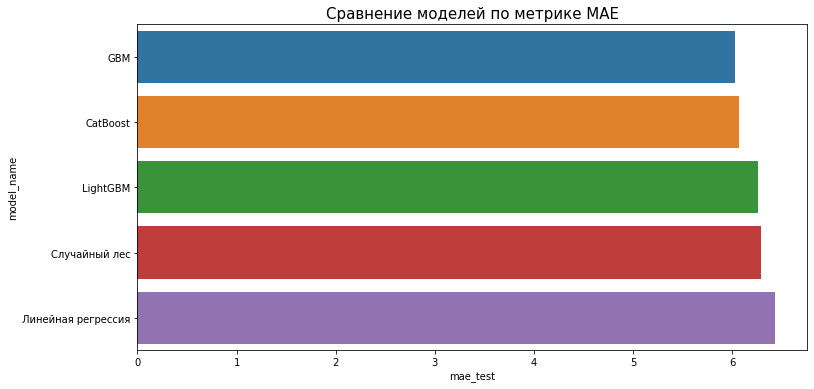

In [117]:
plt.figure(figsize=(12,6))
sns.barplot(y=temp['model_name'], x=temp['mae_test'], orient='h')
plt.title('Cравнение моделей по метрике MAE', size=15);

In [118]:
temp = results.copy().sort_values(by=['time_on_fit, ms'])

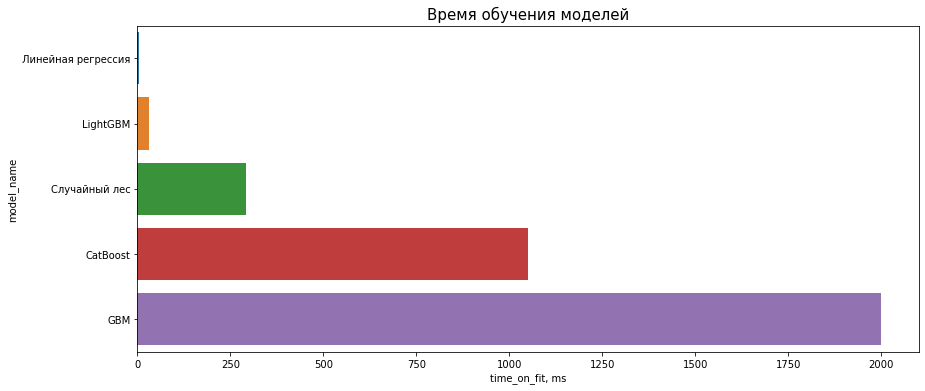

In [119]:
plt.figure(figsize=(14,6))
sns.barplot(y=temp['model_name'], x=temp['time_on_fit, ms'], orient='h')
plt.title('Время обучения моделей', size=15);

По итогам машинного обучения можем выделить 2 модели, который достойны для отправления в продакшн - это CatBoost и GradientBoostingRegressor. Обе показывают хороший результат в районе 6.05 по метрике MAE. Рассмотрим важные признаки ждя этих моделей:

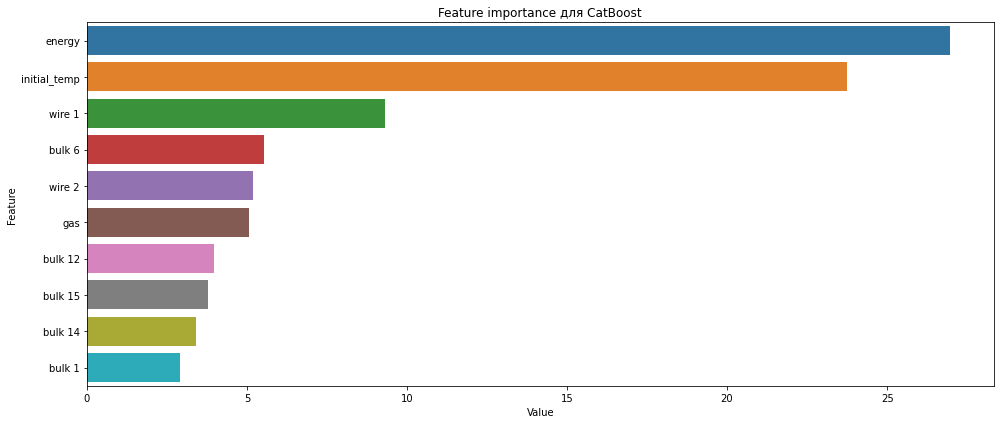

In [120]:
plt.figure(figsize=(14,6))
feature_importance = cbr.feature_importances_
feature_list = list(X_train.columns)
feature_imp = pd.DataFrame(sorted(zip(feature_importance, feature_list)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Feature importance для CatBoost')
plt.tight_layout()
plt.show();

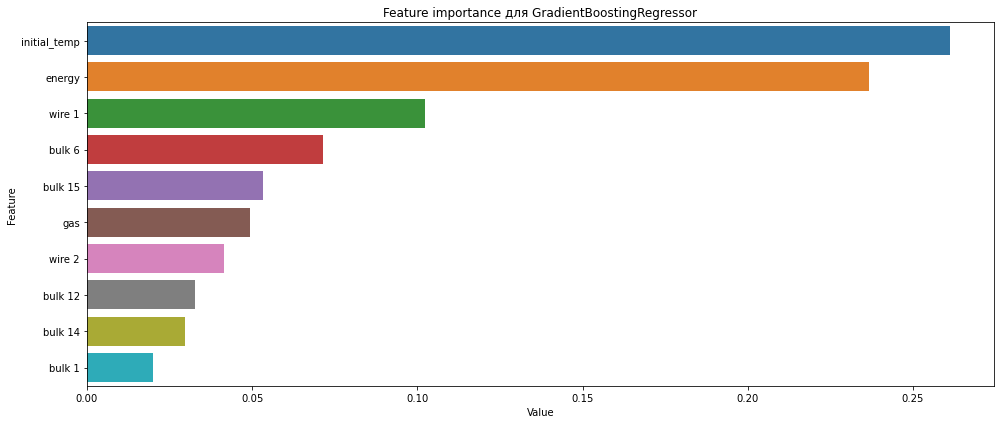

In [121]:
plt.figure(figsize=(14,6))
feature_importance = gbr.feature_importances_
feature_list = list(X_train.columns)
feature_imp = pd.DataFrame(sorted(zip(feature_importance, feature_list)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Feature importance для GradientBoostingRegressor')
plt.tight_layout()
plt.show();

Отметим, что набор важных фич практически идентичен, однако меняется порядок их важности. Для бустинга самым важным параметром является начальная температура, немного отставая идет энергия для электродов. Для с большим отрывом идут различные примеси и газ. Для CatBoost наоборот, энергия идет первой по важности, за ней уже температура, а далее все теже сыпучие материла, провода и тд. 

На данном этапе было обучено 6 моделей: dummy, Линейная регрессия, Случайный лес, LightGBM, GradientBoostingRegressor и СatBoost. Все модели проходят порог по MAE, а Случайный лес, LightGBM, GradientBoostingRegressor и СatBoost имеют почти наилучший результат. Однако стоит выделить две модели, которые мы отправи бизнесу - GradientBoostingRegressor и СatBoost. У обычного бустинга чуть лучше показатель метрики, однако CatBoost чуть быстрее обучается и предсказывает. Эти две модели немного не дотянули до максимального балла, думаю, что нужно немного по-другому предобработать данные, удалить какие-то столбцы или добавить новые фичи. Параметры у финалистов подобраны практически на максимум, результат улучшается не больше чем на доли тысячных.

## Отчет по проекту

В первой части проекта было проведен анализ и предобработка всех предоставленных таблиц. По результатам исследования получили следующее:
1. В таблице о электродах было найдено суммарное время их работы, посчитали итоговую мощность, а на основе времени и мощности выявили энергию (предположительно в МДж). Далее данные были сгруппированы по партиям для дальнейшего объединения.
2. В таблицах о самих сыпучих и проволочных материалах было огромное количество пропусков, которые были заменены на 0, так они означали, что материал не был добавлен в партию. Также оценили данные о времени их добавления. Был сделан вывод, что использование данных со временем не требуется, т.к. в рамках проекта не решается задача временных рядов.
3. Проведен анализ таблицы о добавлении газа. Данные имели минимальное количество пропсуков, а также имели очень близкое к нормальному распределение.
4. В датасете о измереннх в ходе тех. процесса температурах были выявлены выбросы. Их удалили, так как температура стали не может быть меньше 1400 градусов по Цельсию. Также были удалены партии с одним измерением температуры - такие данные не подходят для машинного обучения. Все значения температур были сгруппированы по партиям, при этом в качестве одного из обучающих признаков взято первое измеренное значение, а в качестве таргета - последнее измеренное значение.
4. На последнем этапе все данные были объединены по партиям, где ключевым фактором была температура, поэтому все данные были присоединены к этой таблице. Построили матрицу корреляции и удалили сильно коррелирующие признаки. 

На втором этапе данные были разделены на обучающую и тестовые выборки, а также отмасштабированы. Затем каждая модель была обучена на train выборке и были найдены наилучшие параметры. Была найдена метрика MAE на обучающей выборке у всех моделей. 

На третьем этапе все наши модели (LinearRegression, Random Forest Regressor, LightGBM, GradientBoostingRegressor и CatBoost) с найденными наилучшимии параметрами были обучены на трейн выборке и дали предсказания на основе тестовых данных. Наилучшеми моделями оказались GradientBoostingRegressor и CatBoost, показав результаты по метрике MAE в 6.0328 и 6.0675 соответственно. Отметим, что время обучения у CatBoost ниже. 

По итогу требования заказчика были выполнены, но стоит получше изучить данные, добавить или исключить некоторые признаки, или не удалять выбросы.